In [36]:
# IMPORTS
# A TOF coords adaptation of the listmode PET scan reconstruction from: https://pytomography.readthedocs.io/en/latest/notebooks/t_PETGATE_scat_lm.html

from __future__ import annotations
import torch
import pytomography
from pytomography.metadata import ObjectMeta
from pytomography.metadata.PET import PETLMProjMeta
from pytomography.projectors.PET import PETLMSystemMatrix
from pytomography.algorithms import OSEM, MLEM
from pytomography.io.PET import gate, shared
from pytomography.likelihoods import PoissonLogLikelihood
import os
from pytomography.transforms.shared import GaussianFilter
import matplotlib.pyplot as plt
from pytomography.utils import sss

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

torch.cuda.is_available = lambda: False
print(f"CUDA available: {torch.cuda.is_available()}")
pytomography.device = 'cpu'
print(f"Current device: {pytomography.device}")
torch.cuda.empty_cache()

CUDA available: False
Current device: cpu


In [37]:
# # Visualisation Functions
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from ipywidgets import interact, IntSlider, FloatSlider


def visualize_voxel_tensor_3d(voxel_tensor, initial_min_threshold=None, initial_max_threshold=None, 
                               voxel_size_mm=1.0, world_origin=None, min_threshold=None, max_threshold=None):
    """
    Interactive 3D visualization of voxel tensor with dual threshold sliders.

    Args:
        voxel_tensor: (nx, ny, nz) numpy array with voxel counts
        initial_min_threshold: Initial minimum threshold value for the slider (default: min_val)
        initial_max_threshold: Initial maximum threshold value for the slider (default: max_val)
        voxel_size_mm: Size of each voxel in mm (default: 1.0mm)
        world_origin: (x_min, y_min, z_min) world coordinates of voxel (0,0,0) (optional)
        min_threshold: Minimum threshold value for slider range (optional)
        max_threshold: Maximum threshold value for slider range (optional)
    """
    # Extract non-zero voxel coordinates and values
    coords = np.where(voxel_tensor > 0)
    x_coords, y_coords, z_coords = coords
    values = voxel_tensor[coords]

    # Convert voxel indices to world coordinates if world_origin provided
    if world_origin is not None:
        x_min, y_min, z_min = world_origin
        x_coords_world = x_coords * voxel_size_mm + x_min
        y_coords_world = y_coords * voxel_size_mm + y_min
        z_coords_world = z_coords * voxel_size_mm + z_min
        coord_suffix = " (mm)"
    else:
        x_coords_world = x_coords * voxel_size_mm
        y_coords_world = y_coords * voxel_size_mm
        z_coords_world = z_coords * voxel_size_mm
        coord_suffix = f" (×{voxel_size_mm}mm)"

    # Get value range for sliders
    min_val = float(np.min(values))
    max_val = float(np.max(values))

    # Use user-specified min/max threshold range if provided
    slider_min = min_threshold if min_threshold is not None else min_val
    slider_max = max_threshold if max_threshold is not None else max_val

    # Set initial thresholds with defaults
    if initial_min_threshold is None:
        initial_min_threshold = slider_min
    else:
        initial_min_threshold = max(slider_min, min(slider_max, float(initial_min_threshold)))
    
    if initial_max_threshold is None:
        initial_max_threshold = slider_max
    else:
        initial_max_threshold = max(slider_min, min(slider_max, float(initial_max_threshold)))

    # Ensure min <= max
    if initial_min_threshold > initial_max_threshold:
        initial_min_threshold, initial_max_threshold = initial_max_threshold, initial_min_threshold

    print(f"Voxel value range: {min_val} to {max_val}")
    print(f"Total non-zero voxels: {len(values)}")
    print(f"Initial thresholds: {initial_min_threshold} to {initial_max_threshold}")
    print(f"Slider range: {slider_min} to {slider_max}")
    print(f"Voxel resolution: {voxel_size_mm}mm")

    def update_plot(min_thresh, max_thresh):
        # Ensure min <= max
        if min_thresh > max_thresh:
            min_thresh, max_thresh = max_thresh, min_thresh

        # Filter voxels within threshold range
        mask = (values >= min_thresh) & (values <= max_thresh)
        if not np.any(mask):
            print(f"No voxels in threshold range [{min_thresh}, {max_thresh}]")
            return

        filtered_x = x_coords_world[mask]
        filtered_y = y_coords_world[mask]
        filtered_z = z_coords_world[mask]
        filtered_values = values[mask]

        # Create 3D scatter plot
        fig = go.Figure(data=go.Scatter3d(
            x=filtered_x,
            y=filtered_y,
            z=filtered_z,
            mode='markers',
            marker=dict(
                size=1,
                color=filtered_values,
                colorscale='Viridis',
                opacity=0.8,
                colorbar=dict(title="Voxel Count"),
                line=dict(width=0)
            ),
            text=[f'Count: {v}' for v in filtered_values],
            hovertemplate='<b>Voxel (%{x:.1f}, %{y:.1f}, %{z:.1f})</b><br>%{text}<extra></extra>'
        ))

        fig.update_layout(
            title=f'3D Voxel Visualization (Range: [{min_thresh:.6f}, {max_thresh:.6f}], Showing: {len(filtered_values)} voxels)',
            scene=dict(
                xaxis_title=f'X{coord_suffix}',
                yaxis_title=f'Y{coord_suffix}',
                zaxis_title=f'Z{coord_suffix}',
                camera=dict(
                    eye=dict(x=1.5, y=1.5, z=1.5)
                ),
                aspectmode='cube'
            ),
            width=800,
            height=600
        )

        fig.show()

    # Create interactive sliders with linked constraints
    min_threshold_slider = FloatSlider(
        value=initial_min_threshold,
        min=slider_min,
        max=slider_max,
        step=0.01,
        description='Min Threshold:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )

    max_threshold_slider = FloatSlider(
        value=initial_max_threshold,
        min=slider_min,
        max=slider_max,
        step=0.01,
        description='Max Threshold:',
        continuous_update=False,
        style={'description_width': 'initial'}
    )

    # Link sliders to maintain min <= max constraint
    def on_min_change(change):
        if change['new'] > max_threshold_slider.value:
            max_threshold_slider.value = change['new']

    def on_max_change(change):
        if change['new'] < min_threshold_slider.value:
            min_threshold_slider.value = change['new']

    min_threshold_slider.observe(on_min_change, names='value')
    max_threshold_slider.observe(on_max_change, names='value')

    interact(update_plot, 
             min_thresh=min_threshold_slider, 
             max_thresh=max_threshold_slider)


from plotly.subplots import make_subplots
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, IntSlider, FloatSlider

def plot_cross_sections_interactive(numpy_array, vmax=None, title="Orthogonal Cross Sections"):
    """
    Create an interactive 3D cross-section viewer for a 3D numpy array.
    
    Parameters:
    -----------
    numpy_array : np.ndarray
        3D numpy array to visualize (shape: nx, ny, nz)
    vmax : float, optional
        Maximum value for color scale. If None, uses array maximum
    title : str, optional
        Title for the plot
    """
    
    # Ensure input is numpy array
    if not isinstance(numpy_array, np.ndarray):
        raise ValueError("Input must be a numpy array")
    
    if numpy_array.ndim != 3:
        raise ValueError("Input must be a 3D array")
    
    nx, ny, nz = numpy_array.shape
    
    # Set default vmax if not provided
    if vmax is None:
        vmax = numpy_array.max()
    
    def plot_cross_sections_horizontal(x_idx=nx//2, y_idx=ny//2, z_idx=nz//2, 
                                     vmax_slider=vmax, cmap='Magma'):
        fig = make_subplots(rows=1, cols=3, subplot_titles=[
            f'XY plane @ z={z_idx}',
            f'XZ plane @ y={y_idx}',
            f'YZ plane @ x={x_idx}'
        ])

        # XY plane at z=z_idx
        fig.add_trace(go.Heatmap(
            z=numpy_array[:, :, z_idx].T,
            colorscale=cmap,
            zmax=vmax_slider,
            zmin=0,
            showscale=True,
            name=f'XY @ z={z_idx}'
        ), row=1, col=1)

        # XZ plane at y=y_idx
        fig.add_trace(go.Heatmap(
            z=numpy_array[:, y_idx, :].T,
            colorscale=cmap,
            zmax=vmax_slider,
            zmin=0,
            showscale=True,
            name=f'XZ @ y={y_idx}'
        ), row=1, col=2)

        # YZ plane at x=x_idx
        fig.add_trace(go.Heatmap(
            z=numpy_array[x_idx, :, :].T,
            colorscale=cmap,
            zmax=vmax_slider,
            zmin=0,
            showscale=True,
            name=f'YZ @ x={x_idx}'
        ), row=1, col=3)

        fig.update_layout(
            width=1200,
            height=400,
            title_text=title
        )
        fig.show()

    # Create interactive widget
    interact(
        plot_cross_sections_horizontal,
        x_idx=IntSlider(min=0, max=nx-1, step=1, value=nx//2, description='X index'),
        y_idx=IntSlider(min=0, max=ny-1, step=1, value=ny//2, description='Y index'),
        z_idx=IntSlider(min=0, max=nz-1, step=1, value=nz//2, description='Z index'),
        vmax_slider=FloatSlider(min=0, max=numpy_array.max(), step=0.01, value=vmax, description='vmax'),
        cmap=['Magma','Greys', 'Viridis', 'Cividis', 'Plasma']
    )


In [57]:
# Initial Loading, Filtering, and Coordinate Range Calculation
import numpy as np

# Load coordinates
coordinates = np.load(fr"C:\Users\h\Desktop\PET_Recons\Reconstructions\ground_truth.npy")

# Confirm shape should be (pairs, coords=6), coords are (x1, y1, z1, x2, y2, z2)
print(f"\nData Shape (pairs, coords) : {coordinates.shape}\n")  

# Remove pairs where any coordinate value is exactly 0
filtered_coordinates = coordinates[~np.any(coordinates == 0, axis=1)]
filtered_coordinates = torch.from_numpy(filtered_coordinates).float()
# filtered_coordinates = filtered_coordinates[:100,:]
print(f"Filtered shape: {filtered_coordinates.shape}\n")

# Extract all x, y, z pairs - Coordinates are in the order (x1, y1, z1, x2, y2, z2)
all_xyz = filtered_coordinates.reshape(-1, 3) # Reshape to (pairs, 3) for (x, y, z)
x_vals, y_vals, z_vals = all_xyz[:, 0], all_xyz[:, 1], all_xyz[:, 2]
print(f"x range: min={x_vals.min()}, max={x_vals.max()}")
print(f"y range: min={y_vals.min()}, max={y_vals.max()}")
print(f"z range: min={z_vals.min()}, max={z_vals.max()}")


Data Shape (pairs, coords) : (62660, 6)

Filtered shape: torch.Size([6591, 6])

x range: min=-278.1294250488281, max=278.1666564941406
y range: min=-278.4194641113281, max=277.8843688964844
z range: min=-147.99453735351562, max=147.9492950439453


In [53]:
import torch
import math

def create_intersecting_lines(counts=1000, intersection_point=(0, 0, 0), coord_range=(100, 100, 100)):
    """
    Create a torch tensor of shape (counts, 6) containing lines that all intersect EXACTLY at a specified point.
    
    Args:
        counts: Number of lines to generate
        intersection_point: (x, y, z) coordinates where all lines intersect
        coord_range: (x_range, y_range, z_range) maximum absolute values for coordinates
    
    Returns:
        torch.Tensor: Shape (counts, 6) with format [x1, y1, z1, x2, y2, z2] per row
    """
    
    # Convert to tensors
    intersection = torch.tensor(intersection_point, dtype=torch.float32)
    ranges = torch.tensor(coord_range, dtype=torch.float32)
    
    # Generate random unit directions for each line
    directions = torch.randn(counts, 3)
    directions = directions / torch.norm(directions, dim=1, keepdim=True)
    
    lines = torch.zeros(counts, 6, dtype=torch.float32)
    
    for i in range(counts):
        direction = directions[i]
        
        # Calculate maximum possible distances in positive and negative directions
        # while staying within coordinate bounds
        pos_distances = torch.where(direction > 0, 
                                  (ranges - intersection) / direction,
                                  torch.where(direction < 0,
                                            (intersection + ranges) / (-direction),
                                            torch.tensor(float('inf'))))
        
        neg_distances = torch.where(direction < 0,
                                  (ranges - intersection) / (-direction),
                                  torch.where(direction > 0,
                                            (intersection + ranges) / direction,
                                            torch.tensor(float('inf'))))
        
        # Use the minimum constraint for each direction
        max_pos_distance = torch.min(pos_distances)
        max_neg_distance = torch.min(neg_distances)
        
        # Generate random distances within valid bounds
        # Ensure we don't go to zero distance (which would make both endpoints the same)
        min_distance = 0.1  # Small minimum distance to avoid degenerate lines
        
        if max_pos_distance > min_distance:
            pos_distance = torch.rand(1) * (max_pos_distance - min_distance) + min_distance
        else:
            pos_distance = torch.tensor([min_distance])
            
        if max_neg_distance > min_distance:
            neg_distance = torch.rand(1) * (max_neg_distance - min_distance) + min_distance
        else:
            neg_distance = torch.tensor([min_distance])
        
        # Calculate endpoints
        endpoint1 = intersection + pos_distance * direction
        endpoint2 = intersection - neg_distance * direction
        
        # Store in tensor
        lines[i, :3] = endpoint1
        lines[i, 3:] = endpoint2
    
    return lines

def verify_intersection(lines, intersection_point=(0, 0, 0), tolerance=1e-6):
    """
    Verify that lines pass EXACTLY through the intersection point
    """
    intersection = torch.tensor(intersection_point, dtype=torch.float32)
    
    max_error = 0.0
    for i in range(len(lines)):
        p1 = lines[i, :3]
        p2 = lines[i, 3:]
        
        # Parametric line equation: point = p1 + t*(p2-p1)
        # Find t where line passes through intersection
        direction = p2 - p1
        to_intersection = intersection - p1
        
        # Solve: p1 + t*(p2-p1) = intersection
        # t = dot(to_intersection, direction) / dot(direction, direction)
        t = torch.dot(to_intersection, direction) / torch.dot(direction, direction)
        point_on_line = p1 + t * direction
        
        error = torch.norm(point_on_line - intersection).item()
        max_error = max(max_error, error)
        
        if i < 5:  # Print first 5 for verification
            print(f"Line {i}: error = {error:.10f}, t = {t:.6f}")
    
    print(f"Maximum error across all lines: {max_error:.10f}")
    print(f"All lines pass through intersection: {max_error < tolerance}")
    return max_error < tolerance

# intersection_point=(100, 100, 50)

# custom_lines = create_intersecting_lines(
#     counts=5000, 
#     intersection_point=intersection_point, 
#     coord_range=(150, 175, 130)
# )
# print(f"Custom tensor shape: {custom_lines.shape}")

# verify_intersection(custom_lines, intersection_point=intersection_point)
# filtered_coordinates = custom_lines

In [54]:
# Data shape extraction and basic 3d backprojection
voxel_size = 3.0

def binary_rasterize_lors_3d_dda(pairs_coords, voxel_size_mm=1.0):
    """
    Rasterize lines of response into 3D voxel space using exact 3D DDA traversal.
    
    Args:
        pairs_coords: (N, 6) array where each row is [x1,y1,z1,x2,y2,z2]
        voxel_size_mm: Size of each voxel in mm (default: 1.0mm)
    
    Returns:
        voxel_tensor: (nx, ny, nz) array with line traversal counts
    """
    # World coordinate ranges (mm)
    all_xyz = pairs_coords.reshape(-1, 3) # Reshape to (pairs, 3) for (x, y, z)
    x_vals, y_vals, z_vals = all_xyz[:, 0], all_xyz[:, 1], all_xyz[:, 2]

    x_min = x_vals.min()
    x_max = x_vals.max()
    y_min = y_vals.min()
    y_max = y_vals.max()
    z_min = z_vals.min()
    z_max = z_vals.max()

    # Round the min and max values to voxel boundaries
    x_min = np.floor(x_min / voxel_size_mm) * voxel_size_mm
    x_max = np.ceil(x_max / voxel_size_mm) * voxel_size_mm
    y_min = np.floor(y_min / voxel_size_mm) * voxel_size_mm
    y_max = np.ceil(y_max / voxel_size_mm) * voxel_size_mm
    z_min = np.floor(z_min / voxel_size_mm) * voxel_size_mm
    z_max = np.ceil(z_max / voxel_size_mm) * voxel_size_mm

    # Calculate voxel tensor shape based on resolution
    nx = int((x_max - x_min) / voxel_size_mm)
    ny = int((y_max - y_min) / voxel_size_mm)
    nz = int((z_max - z_min) / voxel_size_mm)
    
    voxel_shape = (nx, ny, nz)
    print(f"Voxel size: {voxel_size_mm}mm")
    print(f"Voxel shape: {voxel_shape} (nx, ny, nz)")
    
    voxel_tensor = np.zeros(voxel_shape, dtype=np.int32)
    
    # Coordinate transformation: world -> voxel indices
    def world_to_voxel(coords):
        x, y, z = coords[:, 0], coords[:, 1], coords[:, 2]
        vx = (x - x_min) / voxel_size_mm
        vy = (y - y_min) / voxel_size_mm
        vz = (z - z_min) / voxel_size_mm
        return np.column_stack([vx, vy, vz])
    
    def dda_3d(p1, p2):
        """3D DDA algorithm - returns list of (x,y,z) voxel indices along line"""
        x1, y1, z1 = p1
        x2, y2, z2 = p2
        
        # Direction and step sizes
        dx = x2 - x1
        dy = y2 - y1
        dz = z2 - z1
        
        # Number of steps is maximum of absolute differences
        steps = int(max(abs(dx), abs(dy), abs(dz)))
        if steps == 0:
            return [(int(round(x1)), int(round(y1)), int(round(z1)))]
        
        # Step increments
        x_inc = dx / steps
        y_inc = dy / steps
        z_inc = dz / steps
        
        voxels = []
        x, y, z = x1, y1, z1
        
        for _ in range(steps + 1):
            vx, vy, vz = int(round(x)), int(round(y)), int(round(z))
            
            # Check bounds
            if 0 <= vx < nx and 0 <= vy < ny and 0 <= vz < nz:
                voxels.append((vx, vy, vz))
            
            x += x_inc
            y += y_inc
            z += z_inc
        
        return voxels
    
    # Transform all coordinates to voxel space
    points1 = world_to_voxel(pairs_coords[:, :3])  # First points
    points2 = world_to_voxel(pairs_coords[:, 3:])  # Second points
    
    # Process each LOR
    for i in range(len(pairs_coords)):
        p1 = points1[i]
        p2 = points2[i]
        
        # Get voxels along this line
        voxels = dda_3d(p1, p2)
        
        # Increment voxel counts
        for vx, vy, vz in voxels:
            voxel_tensor[vx, vy, vz] += 1
    
    return voxel_tensor

voxel_tensor = binary_rasterize_lors_3d_dda(filtered_coordinates, voxel_size_mm=voxel_size)
print(f"Voxel tensor shape: {voxel_tensor.shape}")

# Specify object space for reconstruction
# voxel_space = voxel_tensor.shape # voxels
voxel_space = voxel_tensor.shape # voxels

Voxel size: 3.0mm
Voxel shape: (100, 118, 88) (nx, ny, nz)
Voxel tensor shape: (100, 118, 88)


In [58]:
import plotly.graph_objects as go
from plotly.graph_objs import FigureWidget
import numpy as np
from scipy.spatial import cKDTree
from ipywidgets import interact, IntSlider, VBox
from IPython.display import display

def visualize_lors_and_detectors_3d(coordinates, scanner_info=None, sample_lors=None, 
                                   highlight_detector_ids=None, highlight_color='green',
                                   validate_lor_index=None, verbose=True, 
                                   distance_threshold=5.0):
    """
    3D visualization of LOR endpoints and PET detector positions with interactive slider for LOR validation.
    Camera orientation is preserved during slider interactions.
    
    Parameters:
    -----------
    coordinates : numpy.ndarray
        Shape (n_lors, 6) containing [x1, y1, z1, x2, y2, z2] for each LOR
    scanner_info : dict, optional
        Dictionary containing scanner geometry parameters. If None, only LOR endpoints are visualized.
    sample_lors : int, optional
        Number of LORs to sample for visualization (default: all)
    highlight_detector_ids : list or set, optional
        Detector IDs to highlight with different color (ignored if scanner_info is None)
    highlight_color : str, optional
        Color for highlighted detectors (default: 'green')
    validate_lor_index : int, optional
        Initial LOR index to display in the slider (default: 0)
    verbose : bool, optional
        If False, suppresses all print outputs (default: True)
    distance_threshold : float, optional
        Maximum allowed distance (in mm) between extended endpoints and assigned detectors.
        LOR pairs where either endpoint exceeds this distance are excluded (default: 5.0)
        Only used if scanner_info is provided.
        
    Returns:
    --------
    tuple
        If scanner_info provided: (full_detector_id_pairs, valid_detector_id_pairs, valid_lor_indices)
        If scanner_info is None: (None, None, None)
    """
    
    def extend_endpoints_to_radius(endpoints1, endpoints2, target_radius):
        """
        Extend LOR endpoints along the LOR direction until they reach the target radius.
        """
        # Calculate LOR direction vectors (from endpoint1 to endpoint2)
        lor_directions = endpoints2 - endpoints1
        lor_lengths = np.linalg.norm(lor_directions, axis=1, keepdims=True)
        
        # Avoid division by zero
        lor_lengths = np.where(lor_lengths == 0, 1e-10, lor_lengths)
        lor_unit_vectors = lor_directions / lor_lengths
        
        def find_radius_intersection(start_point, direction, target_radius):
            """Find where a ray intersects the cylinder at target_radius."""
            x0, y0, z0 = start_point.T
            dx, dy, dz = direction.T
            
            # Quadratic equation coefficients: at² + bt + c = 0
            a = dx**2 + dy**2
            b = 2 * (x0 * dx + y0 * dy)
            c = x0**2 + y0**2 - target_radius**2
            
            # Solve quadratic equation
            valid_mask = np.abs(a) > 1e-10  # Direction has xy component
            result = start_point.copy()
            
            if np.any(valid_mask):
                a_valid = a[valid_mask]
                b_valid = b[valid_mask]
                c_valid = c[valid_mask]
                
                discriminant = b_valid**2 - 4 * a_valid * c_valid
                solvable_mask = discriminant >= 0
                
                if np.any(solvable_mask):
                    sqrt_disc = np.sqrt(discriminant[solvable_mask])
                    t1 = (-b_valid[solvable_mask] + sqrt_disc) / (2 * a_valid[solvable_mask])
                    t2 = (-b_valid[solvable_mask] - sqrt_disc) / (2 * a_valid[solvable_mask])
                    
                    # Choose the positive t value
                    t_chosen = np.where(
                        (t1 > 0) & (t2 > 0), np.minimum(t1, t2),
                        np.where(t1 > 0, t1, 
                                np.where(t2 > 0, t2, np.maximum(t1, t2)))
                    )
                    
                    # Calculate intersection points
                    valid_indices = np.where(valid_mask)[0]
                    solvable_indices = valid_indices[solvable_mask]
                    
                    result[solvable_indices] = (start_point[solvable_indices] + 
                                            t_chosen.reshape(-1, 1) * direction[solvable_indices])
            
            return result
        
        # Extend endpoints in OPPOSITE directions along the LOR line
        extended_endpoints1 = find_radius_intersection(endpoints1, -lor_unit_vectors, target_radius)
        extended_endpoints2 = find_radius_intersection(endpoints2, lor_unit_vectors, target_radius)
        
        return extended_endpoints1, extended_endpoints2
    
    # Sample LORs if specified
    if sample_lors is not None and sample_lors < coordinates.shape[0]:
        indices = np.random.choice(coordinates.shape[0], sample_lors, replace=False)
        coordinates_sample = coordinates[indices]
        if verbose:
            print(f"Sampling {sample_lors} LORs out of {coordinates.shape[0]} total")
    else:
        coordinates_sample = coordinates
        if verbose:
            print(f"Visualizing all {coordinates.shape[0]} LORs")
    
    # Extract LOR endpoints
    n_lors = coordinates_sample.shape[0]
    endpoint1 = coordinates_sample[:, :3]  # [x1, y1, z1]
    endpoint2 = coordinates_sample[:, 3:]  # [x2, y2, z2]
    
    # Initialize variables for detector analysis (will remain None if no scanner_info)
    detector_positions = None
    detector_ids = None
    full_detector_id_pairs = None
    valid_detector_id_pairs = None
    valid_lor_indices = None
    extended_endpoint1 = None
    extended_endpoint2 = None
    distances1 = None
    distances2 = None
    
    # Only perform detector analysis if scanner_info is provided
    if scanner_info is not None:
        # Generate detector positions and IDs
        radius = scanner_info['radius']
        crystals_per_ring = scanner_info['NrCrystalsPerRing']
        n_rings = scanner_info['NrRings']
        crystal_axial_spacing = scanner_info['crystalAxialSpacing']
        module_axial_spacing = scanner_info['moduleAxialSpacing']
        module_axial_nr = scanner_info['moduleAxialNr']
        crystals_axial_per_module = scanner_info['crystalAxialNr']
        
        # Calculate total axial extent
        crystals_per_module_axial = crystals_axial_per_module
        modules_span = (module_axial_nr - 1) * module_axial_spacing
        crystals_within_modules_span = (crystals_per_module_axial - 1) * crystal_axial_spacing * module_axial_nr
        total_axial_extent = modules_span + crystals_within_modules_span
        
        # Generate detector positions and IDs
        detector_positions = []
        detector_ids = []
        
        for ring in range(n_rings):
            # Calculate z position for this ring
            if n_rings == 1:
                z_pos = 0.0
            else:
                z_pos = -total_axial_extent/2 + ring * (total_axial_extent / (n_rings - 1))
            
            for crystal in range(crystals_per_ring):
                # Calculate angular position
                angle = 2 * np.pi * crystal / crystals_per_ring
                
                # Convert to Cartesian coordinates
                x_pos = radius * np.cos(angle)
                y_pos = radius * np.sin(angle)
                
                detector_positions.append([x_pos, y_pos, z_pos])
                detector_id = ring * crystals_per_ring + crystal
                detector_ids.append(detector_id)
        
        detector_positions = np.array(detector_positions)
        detector_ids = np.array(detector_ids)
        
        # Calculate detector assignments for all LORs
        extended_endpoint1, extended_endpoint2 = extend_endpoints_to_radius(endpoint1, endpoint2, radius)
        
        # Build KDTree for efficient nearest neighbor search
        kdtree = cKDTree(detector_positions)
        
        # Find nearest detector for each extended endpoint
        _, nearest_indices1 = kdtree.query(extended_endpoint1)
        _, nearest_indices2 = kdtree.query(extended_endpoint2)
        
        # Convert to detector IDs
        full_detector_id_pairs = np.column_stack([
            detector_ids[nearest_indices1],
            detector_ids[nearest_indices2]
        ])
        
        # Calculate distances and apply filtering
        distances1 = np.linalg.norm(extended_endpoint1 - detector_positions[nearest_indices1], axis=1)
        distances2 = np.linalg.norm(extended_endpoint2 - detector_positions[nearest_indices2], axis=1)
        valid_mask = (distances1 <= distance_threshold) & (distances2 <= distance_threshold)
        
        valid_detector_id_pairs = full_detector_id_pairs[valid_mask]
        valid_lor_indices = np.where(valid_mask)[0]
        
        # Print initial statistics
        if verbose:
            print(f"\nDistance Filtering (threshold: {distance_threshold} mm):")
            print(f"Original LORs: {len(full_detector_id_pairs)}")
            print(f"Valid LORs: {len(valid_detector_id_pairs)}")
            print(f"Filtered out: {len(full_detector_id_pairs) - len(valid_detector_id_pairs)}")
            print(f"Filtering efficiency: {len(valid_detector_id_pairs)/len(full_detector_id_pairs)*100:.1f}%")
    else:
        if verbose:
            print("No scanner_info provided - visualizing LOR endpoints only")
    
    # Create the persistent FigureWidget
    fig = FigureWidget()
    
    # Add static background elements that don't change with slider
    all_lor_points = np.vstack([endpoint1, endpoint2])
    bg_opacity = 0.3
    detector_opacity = 0.4
    
    # Add ALL LOR endpoints (static background)
    fig.add_trace(go.Scatter3d(
        x=all_lor_points[:, 0],
        y=all_lor_points[:, 1],
        z=all_lor_points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color='red',
            opacity=bg_opacity,
            line=dict(width=0)
        ),
        name=f'All LOR Endpoints',
        hovertemplate='<b>LOR Endpoint</b><br>' +
                      'X: %{x:.1f} mm<br>' +
                      'Y: %{y:.1f} mm<br>' +
                      'Z: %{z:.1f} mm<extra></extra>'
    ))
    
    # Add detector traces only if scanner_info is provided
    if scanner_info is not None:
        # Prepare detector colors
        if highlight_detector_ids is not None:
            highlight_set = set(highlight_detector_ids)
            highlight_mask = np.isin(detector_ids, list(highlight_set))
            regular_mask = ~highlight_mask
            regular_positions = detector_positions[regular_mask]
            highlight_positions = detector_positions[highlight_mask]
            regular_ids = detector_ids[regular_mask]
            highlight_ids = detector_ids[highlight_mask]
            
            if verbose:
                print(f"Highlighting {len(highlight_positions)} detectors: {sorted(highlight_set)}")
        else:
            regular_positions = detector_positions
            highlight_positions = np.array([]).reshape(0, 3)
            regular_ids = detector_ids
            highlight_ids = np.array([])
        
        # Add regular detectors (static)
        if len(regular_positions) > 0:
            fig.add_trace(go.Scatter3d(
                x=regular_positions[:, 0],
                y=regular_positions[:, 1],
                z=regular_positions[:, 2],
                mode='markers',
                marker=dict(
                    size=3,
                    color='blue',
                    opacity=detector_opacity,
                    symbol='diamond',
                    line=dict(width=0)
                ),
                name='Regular Detectors',
                customdata=regular_ids,
                hovertemplate='<b>Detector ID: %{customdata}</b><br>' +
                              'X: %{x:.1f} mm<br>' +
                              'Y: %{y:.1f} mm<br>' +
                              'Z: %{z:.1f} mm<extra></extra>'
            ))
        
        # Add highlighted detectors (static)
        if len(highlight_positions) > 0:
            fig.add_trace(go.Scatter3d(
                x=highlight_positions[:, 0],
                y=highlight_positions[:, 1],
                z=highlight_positions[:, 2],
                mode='markers',
                marker=dict(
                    size=5,
                    color=highlight_color,
                    opacity=1.0,
                    symbol='diamond',
                    line=dict(width=1, color='black')
                ),
                name=f'Highlighted Detectors ({highlight_color})',
                customdata=highlight_ids,
                hovertemplate='<b>Highlighted Detector ID: %{customdata}</b><br>' +
                              'X: %{x:.1f} mm<br>' +
                              'Y: %{y:.1f} mm<br>' +
                              'Z: %{z:.1f} mm<extra></extra>'
            ))
    
    # Define trace names based on whether scanner_info is provided
    if scanner_info is not None:
        trace_names = [
            'LOR - Original Endpoints',
            'LOR - Extended Endpoints', 
            'LOR - Assigned Detectors',
            'LOR - Original Line',
            'Extension Path 1',
            'Extension Path 2', 
            'Detector Assignment 1',
            'Detector Assignment 2'
        ]
    else:
        trace_names = [
            'LOR - Original Endpoints',
            'LOR - Original Line'
        ]
    
    # Add empty traces that will be populated by slider updates
    for i, name in enumerate(trace_names):
        fig.add_trace(go.Scatter3d(
            x=[], y=[], z=[],
            mode='markers' if 'Endpoints' in name or 'Detectors' in name else 'lines',
            name=name,
            showlegend=True if 'Endpoints' in name or 'Detectors' in name else False
        ))
    
    # Set initial layout
    title_text = '3D LOR Validation with Persistent Camera View' if scanner_info is not None else '3D LOR Point Cloud Visualization'
    fig.update_layout(
        title=title_text,
        scene=dict(
            xaxis_title='X (mm)',
            yaxis_title='Y (mm)',
            zaxis_title='Z (mm)',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5),
                center=dict(x=0, y=0, z=0),
                up=dict(x=0, y=0, z=1)
            ),
            aspectmode='cube'
        ),
        width=900,
        height=700,
        legend=dict(
            x=0.02,
            y=0.98,
            bgcolor='rgba(255,255,255,0.8)'
        )
    )
    
    def update_lor_visualization(lor_index):
        """Update only the LOR-specific traces without recreating the entire plot"""
        
        if lor_index >= coordinates_sample.shape[0]:
            # Clear all dynamic traces if invalid index
            static_traces_count = 1  # All LOR endpoints
            if scanner_info is not None:
                static_traces_count += 1  # Regular detectors
                if highlight_detector_ids is not None:
                    static_traces_count += 1  # Highlighted detectors
            
            with fig.batch_update():
                for i in range(len(trace_names)):
                    fig.data[static_traces_count + i].update(x=[], y=[], z=[])
                title_suffix = 'LOR Validation' if scanner_info is not None else 'LOR Point Cloud Visualization'
                fig.layout.title.text = f'3D {title_suffix}: LOR {lor_index} (INVALID INDEX)'
            return
        
        # Get the specific LOR's data
        val_endpoint1 = coordinates_sample[lor_index, :3]
        val_endpoint2 = coordinates_sample[lor_index, 3:]
        
        # Calculate how many static traces we have
        static_traces_count = 1  # All LOR endpoints
        if scanner_info is not None:
            static_traces_count += 1  # Regular detectors
            if highlight_detector_ids is not None:
                static_traces_count += 1  # Highlighted detectors
        
        with fig.batch_update():
            if scanner_info is not None:
                # Get validation data for the selected LOR
                original_lor_survived = lor_index in valid_lor_indices
                val_extended1 = extended_endpoint1[lor_index]
                val_extended2 = extended_endpoint2[lor_index]
                
                # Get detector assignments
                val_detector1_id = full_detector_id_pairs[lor_index, 0]
                val_detector2_id = full_detector_id_pairs[lor_index, 1]
                
                # Find detector positions
                det_idx1 = np.where(detector_ids == val_detector1_id)[0][0]
                det_idx2 = np.where(detector_ids == val_detector2_id)[0][0]
                val_detector1_pos = detector_positions[det_idx1]
                val_detector2_pos = detector_positions[det_idx2]
                
                dist1, dist2 = distances1[lor_index], distances2[lor_index]
                
                # Color coding based on validity
                endpoint_color = 'orange' if original_lor_survived else 'red'
                extended_color = 'purple' if original_lor_survived else 'magenta'
                detector_color = 'yellow' if original_lor_survived else 'pink'
                line_color_1 = 'orange' if original_lor_survived else 'red'
                line_color_2 = 'purple' if original_lor_survived else 'magenta'
                
                status_text = f"VALID (≤{distance_threshold}mm)" if original_lor_survived else f"FILTERED (>{distance_threshold}mm)"
                
                # Update traces in the exact order they were created in trace_names:
                # 0: 'LOR - Original Endpoints'
                fig.data[static_traces_count + 0].update(
                    x=[val_endpoint1[0], val_endpoint2[0]],
                    y=[val_endpoint1[1], val_endpoint2[1]],
                    z=[val_endpoint1[2], val_endpoint2[2]],
                    marker=dict(
                        size=8,
                        color=endpoint_color,
                        opacity=1.0,
                        symbol='circle',
                        line=dict(width=2, color='black')
                    ),
                    name=f'LOR {lor_index} - Original Endpoints ({status_text})',
                    hovertemplate='<b>Original Endpoint</b><br>' +
                                  'X: %{x:.1f} mm<br>' +
                                  'Y: %{y:.1f} mm<br>' +
                                  'Z: %{z:.1f} mm<extra></extra>'
                )
                
                # 1: 'LOR - Extended Endpoints'
                fig.data[static_traces_count + 1].update(
                    x=[val_extended1[0], val_extended2[0]],
                    y=[val_extended1[1], val_extended2[1]],
                    z=[val_extended1[2], val_extended2[2]],
                    marker=dict(
                        size=6,
                        color=extended_color,
                        opacity=1.0,
                        symbol='square',
                        line=dict(width=2, color='black')
                    ),
                    name=f'LOR {lor_index} - Extended Endpoints',
                    hovertemplate='<b>Extended Endpoint</b><br>' +
                                  'X: %{x:.1f} mm<br>' +
                                  'Y: %{y:.1f} mm<br>' +
                                  'Z: %{z:.1f} mm<extra></extra>'
                )
                
                # 2: 'LOR - Assigned Detectors'
                fig.data[static_traces_count + 2].update(
                    x=[val_detector1_pos[0], val_detector2_pos[0]],
                    y=[val_detector1_pos[1], val_detector2_pos[1]],
                    z=[val_detector1_pos[2], val_detector2_pos[2]],
                    marker=dict(
                        size=8,
                        color=detector_color,
                        opacity=1.0,
                        symbol='diamond-open',
                        line=dict(width=2, color='black')
                    ),
                    name=f'LOR {lor_index} - Assigned Detectors (d1:{dist1:.1f}mm, d2:{dist2:.1f}mm)',
                    customdata=[val_detector1_id, val_detector2_id],
                    hovertemplate='<b>Assigned Detector ID: %{customdata}</b><br>' +
                                  'X: %{x:.1f} mm<br>' +
                                  'Y: %{y:.1f} mm<br>' +
                                  'Z: %{z:.1f} mm<extra></extra>'
                )
                
                # 3: 'LOR - Original Line'
                fig.data[static_traces_count + 3].update(
                    x=[val_endpoint1[0], val_endpoint2[0]],
                    y=[val_endpoint1[1], val_endpoint2[1]],
                    z=[val_endpoint1[2], val_endpoint2[2]],
                    line=dict(color='black', width=6),
                    name=f'LOR {lor_index} - Original LOR Line'
                )
                
                # 4: 'Extension Path 1'
                fig.data[static_traces_count + 4].update(
                    x=[val_endpoint1[0], val_extended1[0]],
                    y=[val_endpoint1[1], val_extended1[1]],
                    z=[val_endpoint1[2], val_extended1[2]],
                    line=dict(color=line_color_1, width=4, dash='dash')
                )
                
                # 5: 'Extension Path 2'
                fig.data[static_traces_count + 5].update(
                    x=[val_endpoint2[0], val_extended2[0]],
                    y=[val_endpoint2[1], val_extended2[1]],
                    z=[val_endpoint2[2], val_extended2[2]],
                    line=dict(color=line_color_1, width=4, dash='dash')
                )
                
                # 6: 'Detector Assignment 1'
                fig.data[static_traces_count + 6].update(
                    x=[val_extended1[0], val_detector1_pos[0]],
                    y=[val_extended1[1], val_detector1_pos[1]],
                    z=[val_extended1[2], val_detector1_pos[2]],
                    line=dict(color=line_color_2, width=4, dash='dot')
                )
                
                # 7: 'Detector Assignment 2'
                fig.data[static_traces_count + 7].update(
                    x=[val_extended2[0], val_detector2_pos[0]],
                    y=[val_extended2[1], val_detector2_pos[1]],
                    z=[val_extended2[2], val_detector2_pos[2]],
                    line=dict(color=line_color_2, width=4, dash='dot')
                )
                
                # Update title
                fig.layout.title.text = f'3D LOR Validation: LOR {lor_index} ({status_text})'
                
            else:
                # Point cloud mode - only update original endpoints and line
                # 0: 'LOR - Original Endpoints'
                fig.data[static_traces_count + 0].update(
                    x=[val_endpoint1[0], val_endpoint2[0]],
                    y=[val_endpoint1[1], val_endpoint2[1]],
                    z=[val_endpoint1[2], val_endpoint2[2]],
                    marker=dict(
                        size=8,
                        color='orange',
                        opacity=1.0,
                        symbol='circle',
                        line=dict(width=2, color='black')
                    ),
                    name=f'LOR {lor_index} - Original Endpoints',
                    hovertemplate='<b>Original Endpoint</b><br>' +
                                  'X: %{x:.1f} mm<br>' +
                                  'Y: %{y:.1f} mm<br>' +
                                  'Z: %{z:.1f} mm<extra></extra>'
                )
                
                # 1: 'LOR - Original Line'
                fig.data[static_traces_count + 1].update(
                    x=[val_endpoint1[0], val_endpoint2[0]],
                    y=[val_endpoint1[1], val_endpoint2[1]],
                    z=[val_endpoint1[2], val_endpoint2[2]],
                    line=dict(color='black', width=6),
                    name=f'LOR {lor_index} - Original LOR Line'
                )
                
                # Update title for point cloud mode
                fig.layout.title.text = f'3D LOR Point Cloud: LOR {lor_index}'
    
    # Set up the interactive slider
    max_lor_index = coordinates_sample.shape[0] - 1
    initial_lor_index = validate_lor_index if validate_lor_index is not None else 0
    
    slider = IntSlider(
        value=initial_lor_index,
        min=0,
        max=max_lor_index,
        step=1,
        description='LOR Index:',
        style={'description_width': 'initial'},
        layout={'width': '400px'}
    )
    
    if verbose:
        print(f"\nInteractive slider created for LOR indices 0-{max_lor_index}")
        if scanner_info is not None:
            print(f"Distance threshold: {distance_threshold} mm")
    
    # Connect slider to update function
    def on_slider_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            update_lor_visualization(change['new'])
    
    slider.observe(on_slider_change)
    
    # Initialize with the starting LOR
    update_lor_visualization(initial_lor_index)
    
    # Display the widget and figure
    display(VBox([slider, fig]))
    
    return full_detector_id_pairs, valid_detector_id_pairs, valid_lor_indices

full_detector_ids, valid_detector_ids, valid_indices = visualize_lors_and_detectors_3d(
                                                    filtered_coordinates.numpy(),
                                                    # info,
                                                    #  highlight_detector_ids=[0, 1, 5, 4370],
                                                     verbose=True,
                                                    #  verbose=False,
                                                    #  validate_lor_index=13,
                                                     distance_threshold=5.0,)


Visualizing all 6591 LORs
No scanner_info provided - visualizing LOR endpoints only

Interactive slider created for LOR indices 0-6590


In [56]:
import torch
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from typing import Union, Optional, Tuple

def classical_4d_sinogram(
    data: Union[torch.Tensor, np.ndarray],
    info: Optional[dict] = None,
    weights: Optional[Union[torch.Tensor, np.ndarray]] = None,
    input_type: str = "lor_coordinates",
    n_radial_bins: Optional[int] = None,
    n_angular_bins: Optional[int] = None,
    n_axial_bins: Optional[int] = None,
    n_polar_bins: Optional[int] = None,
    radial_range: Optional[Tuple[float, float]] = None,
    angular_range: Tuple[float, float] = (0.0, np.pi),
    axial_range: Optional[Tuple[float, float]] = None,
    polar_range: Optional[Tuple[float, float]] = None,
    angular_bin_size_deg: float = 1.0,
    polar_bin_size_deg: float = 1.0,
    device: str = "cpu"
) -> Tuple[torch.Tensor, dict]:
    """
    Converts PET listmode data to classical 4D sinogram representation.
    
    The 4D sinogram has dimensions:
    - Radial position (s): SIGNED perpendicular distance of LOR from scanner center
    - Azimuthal angle (φ): Projection angle within transverse (xy) plane  
    - Axial position (z): SIGNED location along scanner length (z-axis)
    - Polar angle (δ): Ring difference/oblique angle relative to axial direction
    
    Args:
        data (torch.Tensor or np.ndarray): Input data, either detector IDs (Nx2 or Nx3 for TOF) or 
                           LOR coordinates (Nx6 as [x1,y1,z1,x2,y2,z2])
        info (dict, optional): PET scanner geometry information dictionary. 
                             Required only for "detector_ids" input_type. Defaults to None.
        weights (torch.Tensor or np.ndarray, optional): Event weights for binning. Defaults to None.
        input_type (str): Either "detector_ids" or "lor_coordinates". Defaults to "lor_coordinates".
        n_radial_bins (int, optional): Number of radial bins. Auto-computed if None.
        n_angular_bins (int, optional): Number of angular bins. Auto-computed from angular_bin_size_deg if None.
        n_axial_bins (int, optional): Number of axial bins. Auto-computed if None.
        n_polar_bins (int, optional): Number of polar angle bins. Auto-computed from polar_bin_size_deg if None.
        radial_range (Tuple[float, float], optional): (min, max) SIGNED radial distance in mm. Auto-computed if None.
        angular_range (Tuple[float, float]): Angular range in radians. Defaults to (0, π).
        axial_range (Tuple[float, float], optional): (min, max) SIGNED axial positions in mm. Auto-computed if None.
        polar_range (Tuple[float, float], optional): Polar angle range in radians. Auto-computed if None.
        angular_bin_size_deg (float): Angular bin size in degrees. Default 1.0°.
        polar_bin_size_deg (float): Polar angle bin size in degrees. Default 1.0°.
        device (str): Computation device. Defaults to "cpu".
        
    Returns:
        Tuple[torch.Tensor, dict]: (4D sinogram, metadata dictionary)
            - sinogram: shape (n_radial, n_angular, n_axial, n_polar)
            - metadata: coordinate ranges and bin information
    """
    
    def detector_ids_to_lor_coordinates(detector_ids: torch.Tensor, scanner_info: dict) -> torch.Tensor:
        """Convert detector IDs to LOR endpoint coordinates."""
        if scanner_info is None:
            raise ValueError("scanner_info (info parameter) is required when input_type='detector_ids'")
            
        # Extract scanner parameters
        radius = scanner_info['radius']
        crystals_per_ring = scanner_info['NrCrystalsPerRing']
        n_rings = scanner_info['NrRings']
        crystal_axial_spacing = scanner_info['crystalAxialSpacing']
        module_axial_spacing = scanner_info['moduleAxialSpacing']
        module_axial_nr = scanner_info['moduleAxialNr']
        crystals_axial_per_module = scanner_info['crystalAxialNr']
        
        # Calculate axial positioning
        crystals_per_module_axial = crystals_axial_per_module
        modules_span = (module_axial_nr - 1) * module_axial_spacing
        crystals_within_modules_span = (crystals_per_module_axial - 1) * crystal_axial_spacing * module_axial_nr
        total_axial_extent = modules_span + crystals_within_modules_span
        
        # Convert detector IDs to ring and crystal indices
        detector_ids_2d = detector_ids[:, :2]  # Take first two columns for detector pair
        ring_ids = (detector_ids_2d // crystals_per_ring).long()
        crystal_ids = (detector_ids_2d % crystals_per_ring).long()
        
        # Calculate coordinates for both detectors
        coordinates = torch.zeros(detector_ids.shape[0], 6, device=device)
        
        for i in range(2):  # For both detectors in the pair
            # Angular position
            angles = 2 * np.pi * crystal_ids[:, i].float() / crystals_per_ring
            
            # Cartesian coordinates in transverse plane
            coordinates[:, i*3] = radius * torch.cos(angles)     # x
            coordinates[:, i*3+1] = radius * torch.sin(angles)   # y
            
            # Axial position (z)
            if n_rings == 1:
                coordinates[:, i*3+2] = 0.0
            else:
                z_positions = -total_axial_extent/2 + ring_ids[:, i].float() * (total_axial_extent / (n_rings - 1))
                coordinates[:, i*3+2] = z_positions
        
        return coordinates
    
    def lor_coordinates_to_sinogram_params(lor_coords: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """Convert LOR coordinates to classical sinogram parameters."""
        # Extract endpoints
        x1, y1, z1 = lor_coords[:, 0], lor_coords[:, 1], lor_coords[:, 2]
        x2, y2, z2 = lor_coords[:, 3], lor_coords[:, 4], lor_coords[:, 5]
        
        # Calculate LOR direction vector
        dx = x2 - x1
        dy = y2 - y1
        dz = z2 - z1
        
        # 1. SIGNED Radial position (s): perpendicular distance from origin to LOR
        # Using formula: s = (x1 * dy - y1 * dx) / sqrt(dx² + dy²)
        # This gives proper signed distance
        cross_product_z = x1 * dy - y1 * dx  # z-component of cross product (signed)
        lor_length_xy = torch.sqrt(dx**2 + dy**2)
        radial_pos = cross_product_z / (lor_length_xy + 1e-10)  # Keep sign!
        
        # 2. Azimuthal angle (φ): projection angle in xy plane
        # Angle of the LOR direction (not perpendicular)
        azimuthal_angle = torch.atan2(dy, dx)
        
        # Normalize angle to [0, π] for proper sinogram representation
        # This handles the symmetry: LOR from A->B same as B->A
        azimuthal_angle = torch.fmod(azimuthal_angle + 2*np.pi, np.pi)
        
        # Adjust radial sign for angles > π/2 to maintain consistency
        mask = azimuthal_angle > np.pi/2
        azimuthal_angle[mask] = azimuthal_angle[mask] - np.pi
        radial_pos[mask] = -radial_pos[mask]
        
        # Ensure angles are in [0, π]
        azimuthal_angle = torch.fmod(azimuthal_angle + np.pi, np.pi)
        
        # 3. SIGNED Axial position (z): midpoint along z-axis (keep sign)
        axial_pos = (z1 + z2) / 2
        
        # 4. Polar angle (δ): angle relative to transverse plane
        # This captures the "obliqueness" of the LOR
        lor_length_3d = torch.sqrt(dx**2 + dy**2 + dz**2)
        polar_angle = torch.asin(torch.abs(dz) / (lor_length_3d + 1e-10))
        
        return radial_pos, azimuthal_angle, axial_pos, polar_angle
    
    # Convert to torch tensor if needed and move to specified device
    if isinstance(data, np.ndarray):
        data = torch.from_numpy(data).float()
    data = data.to(device)
    
    if weights is not None:
        if isinstance(weights, np.ndarray):
            weights = torch.from_numpy(weights).float()
        weights = weights.to(device)
    
    # Convert detector IDs to LOR coordinates if needed
    if input_type == "detector_ids":
        if info is None:
            raise ValueError("info parameter is required when input_type='detector_ids'")
        lor_coords = detector_ids_to_lor_coordinates(data, info)
    elif input_type == "lor_coordinates":
        lor_coords = data
    else:
        raise ValueError("input_type must be 'detector_ids' or 'lor_coordinates'")
    
    # Convert to sinogram parameters
    radial_pos, azimuthal_angle, axial_pos, polar_angle = lor_coordinates_to_sinogram_params(lor_coords)
    
    # Determine angular bins from bin size
    if n_angular_bins is None:
        angular_extent = angular_range[1] - angular_range[0]
        angular_extent_deg = angular_extent * 180 / np.pi
        n_angular_bins = int(np.ceil(angular_extent_deg / angular_bin_size_deg))
    
    # Determine polar bins from bin size
    if n_polar_bins is None:
        if polar_range is None:
            # Estimate polar range first
            if input_type == "detector_ids" and info is not None:
                max_z_diff = info['NrRings'] * info['crystalAxialSpacing']
                max_polar = np.arctan(max_z_diff / (2 * info['radius']))
            else:
                max_polar = polar_angle.max().item() * 1.1
            polar_extent = max_polar
        else:
            polar_extent = polar_range[1] - polar_range[0]
        
        polar_extent_deg = polar_extent * 180 / np.pi
        n_polar_bins = int(np.ceil(polar_extent_deg / polar_bin_size_deg))
    
    # Determine binning parameters if not provided
    # For LOR coordinates, estimate reasonable defaults from the data
    if input_type == "lor_coordinates":
        # Estimate scanner dimensions from LOR data
        all_coords = lor_coords.reshape(-1, 3)  # Flatten to all endpoint coordinates
        estimated_radius = torch.sqrt(all_coords[:, 0]**2 + all_coords[:, 1]**2).max().item()
        axial_extent = (all_coords[:, 2].max() - all_coords[:, 2].min()).item()
        
        if n_radial_bins is None:
            n_radial_bins = min(200, int(estimated_radius / 2))  # ~2mm bins
        if n_axial_bins is None:
            n_axial_bins = min(100, max(20, int(axial_extent / 4)))  # ~4mm bins
            
    else:  # detector_ids case
        if n_radial_bins is None:
            n_radial_bins = info['NrCrystalsPerRing'] // 2
        if n_axial_bins is None:
            n_axial_bins = info['NrRings']
    
    # Determine ranges if not provided
    if radial_range is None:
        if input_type == "detector_ids" and info is not None:
            max_radial = info['radius'] * 0.9
            radial_range = (-max_radial, max_radial)  # SIGNED range
        else:
            # Estimate from data - use full signed range
            max_radial = torch.max(torch.abs(radial_pos)).item() * 1.1
            radial_range = (-max_radial, max_radial)  # SIGNED range
    
    if axial_range is None:
        if input_type == "detector_ids" and info is not None:
            total_axial_extent = (info['moduleAxialNr'] - 1) * info['moduleAxialSpacing'] + \
                                (info['crystalAxialNr'] - 1) * info['crystalAxialSpacing'] * info['moduleAxialNr']
            axial_range = (-total_axial_extent/2, total_axial_extent/2)  # SIGNED range
        else:
            # Use data-driven axial range (already signed)
            axial_min = axial_pos.min().item()
            axial_max = axial_pos.max().item()
            axial_range = (axial_min, axial_max)
    
    if polar_range is None:
        if input_type == "detector_ids" and info is not None:
            # Maximum polar angle based on scanner geometry
            max_z_diff = info['NrRings'] * info['crystalAxialSpacing']
            max_polar = np.arctan(max_z_diff / (2 * info['radius']))
        else:
            # Estimate from data
            max_polar = polar_angle.max().item() * 1.1
        polar_range = (0.0, max_polar)
    
    # Create bin edges
    radial_edges = torch.linspace(radial_range[0], radial_range[1], n_radial_bins + 1, device=device)
    angular_edges = torch.linspace(angular_range[0], angular_range[1], n_angular_bins + 1, device=device)
    axial_edges = torch.linspace(axial_range[0], axial_range[1], n_axial_bins + 1, device=device)
    polar_edges = torch.linspace(polar_range[0], polar_range[1], n_polar_bins + 1, device=device)
    
    # Stack coordinates for histogramming
    coords_4d = torch.stack([radial_pos, azimuthal_angle, axial_pos, polar_angle], dim=1)
    
    # Create 4D histogram
    bin_edges = [radial_edges, angular_edges, axial_edges, polar_edges]
    
    sinogram_4d = torch.histogramdd(
        coords_4d,
        bins=bin_edges,
        weight=weights
    )[0]
    
    # Create metadata dictionary
    metadata = {
        'shape': sinogram_4d.shape,
        'radial_range': radial_range,
        'angular_range': angular_range,
        'axial_range': axial_range,
        'polar_range': polar_range,
        'n_radial_bins': n_radial_bins,
        'n_angular_bins': n_angular_bins,
        'n_axial_bins': n_axial_bins,
        'n_polar_bins': n_polar_bins,
        'angular_bin_size_deg': angular_bin_size_deg,
        'polar_bin_size_deg': polar_bin_size_deg,
        'radial_coords': torch.linspace(radial_range[0], radial_range[1], n_radial_bins),
        'angular_coords': torch.linspace(angular_range[0], angular_range[1], n_angular_bins),
        'axial_coords': torch.linspace(axial_range[0], axial_range[1], n_axial_bins),
        'polar_coords': torch.linspace(polar_range[0], polar_range[1], n_polar_bins),
        'input_type': input_type,
        'total_counts': float(torch.sum(sinogram_4d)),
        'non_zero_elements': int(torch.sum(sinogram_4d > 0))
    }
    
    return sinogram_4d, metadata


def plot_sinogram_key_projections(
    data: Union[torch.Tensor, np.ndarray] = None,
    info: Optional[dict] = None,
    weights: Optional[Union[torch.Tensor, np.ndarray]] = None,
    input_type: str = "lor_coordinates",
    angular_bin_size_deg: float = 1.0,
    polar_bin_size_deg: float = 1.0,
    device: str = "cpu",
    sinogram_4d: Optional[torch.Tensor] = None,
    metadata: Optional[dict] = None,
    log_scale: bool = False,
    title_prefix: str = ""
):
    """
    Create two focused plots from 4D sinogram data or generate sinogram from input data:
    1. Radial Distance vs Azimuthal Angle (classic sinogram view)
    2. Axial Distance vs Polar Angle (oblique LOR view)
    
    Args:
        data (torch.Tensor or np.ndarray, optional): Input data for sinogram generation
        info (dict, optional): Scanner geometry (required for detector_ids input_type)
        weights (torch.Tensor or np.ndarray, optional): Event weights for binning
        input_type (str): "lor_coordinates" or "detector_ids"
        angular_bin_size_deg (float): Angular bin size in degrees
        polar_bin_size_deg (float): Polar bin size in degrees  
        device (str): Computation device
        sinogram_4d (torch.Tensor, optional): Pre-computed 4D sinogram
        metadata (dict, optional): Metadata from classical_4d_sinogram function
        log_scale (bool): Whether to use log scale for visualization
        title_prefix (str): Prefix for plot titles
        
    Returns:
        Tuple[torch.Tensor, dict]: (sinogram_4d, metadata) if generating from data
    """
    
    # Generate sinogram if not provided
    if sinogram_4d is None:
        if data is None:
            raise ValueError("Either 'data' or 'sinogram_4d' must be provided")
        
        sinogram_4d, metadata = classical_4d_sinogram(
            data=data,
            info=info,
            weights=weights,
            input_type=input_type,
            angular_bin_size_deg=angular_bin_size_deg,
            polar_bin_size_deg=polar_bin_size_deg,
            device=device
        )
    
    # Convert to numpy if tensor
    if torch.is_tensor(sinogram_4d):
        sinogram_data = sinogram_4d.cpu().numpy()
    else:
        sinogram_data = sinogram_4d
    
    n_radial, n_angular, n_axial, n_polar = sinogram_data.shape
    
    # Use metadata if provided, otherwise use defaults
    if metadata is not None:
        radial_coords = metadata['radial_coords'].cpu().numpy() if torch.is_tensor(metadata['radial_coords']) else metadata['radial_coords']
        angular_coords = metadata['angular_coords'].cpu().numpy() if torch.is_tensor(metadata['angular_coords']) else metadata['angular_coords']
        axial_coords = metadata['axial_coords'].cpu().numpy() if torch.is_tensor(metadata['axial_coords']) else metadata['axial_coords']
        polar_coords = metadata['polar_coords'].cpu().numpy() if torch.is_tensor(metadata['polar_coords']) else metadata['polar_coords']
        radial_range = metadata['radial_range']
        angular_range = metadata['angular_range']
        axial_range = metadata['axial_range']
        polar_range = metadata['polar_range']
    else:
        # Default ranges
        radial_range = (-300, 300)
        angular_range = (0, np.pi)
        axial_range = (-100, 100)
        polar_range = (0, np.pi/4)
        radial_coords = np.linspace(radial_range[0], radial_range[1], n_radial)
        angular_coords = np.linspace(angular_range[0], angular_range[1], n_angular)
        axial_coords = np.linspace(axial_range[0], axial_range[1], n_axial)
        polar_coords = np.linspace(polar_range[0], polar_range[1], n_polar)
    
    # Create the two key projections
    # 1. Radial vs Angular (sum over axial and polar dimensions)
    proj_radial_angular = np.sum(sinogram_data, axis=(2, 3))
    
    # 2. Axial vs Polar (sum over radial and angular dimensions)
    proj_axial_polar = np.sum(sinogram_data, axis=(0, 1))
    
    # Apply log scale if requested
    if log_scale:
        proj_radial_angular = np.log10(proj_radial_angular + 1e-10)
        proj_axial_polar = np.log10(proj_axial_polar + 1e-10)
        colorbar_title = "Log10(Counts)"
        scale_suffix = " (Log Scale)"
    else:
        colorbar_title = "Counts"
        scale_suffix = ""
    
    # Create subplots with 1 row, 2 columns
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=(
            f'Radial Distance vs Azimuthal Angle{scale_suffix}',
            f'Axial Position vs Polar Angle{scale_suffix}'
        ),
        horizontal_spacing=0.15
    )
    
    # Plot 1: Radial vs Angular (Classic Sinogram)
    fig.add_trace(
        go.Heatmap(
            z=proj_radial_angular,
            x=angular_coords * 180/np.pi,  # Convert to degrees for display
            y=radial_coords,
            colorbar=dict(
                title=colorbar_title,
                x=0.42,  # Position between subplots
                len=0.8
            ),
            showscale=True,
            hovertemplate='<b>Azimuthal Angle: %{x:.1f}°</b><br>' +
                         '<b>Radial Distance: %{y:.1f} mm</b><br>' +
                         '<b>Count: %{z:.3f}</b><extra></extra>'
        ),
        row=1, col=1
    )
    
    # Plot 2: Axial vs Polar
    fig.add_trace(
        go.Heatmap(
            z=proj_axial_polar,
            x=polar_coords * 180/np.pi,  # Convert to degrees for display
            y=axial_coords,
            colorbar=dict(
                title=colorbar_title,
                x=1.02,  # Position to the right
                len=0.8
            ),
            showscale=True,
            hovertemplate='<b>Polar Angle: %{x:.1f}°</b><br>' +
                         '<b>Axial Position: %{y:.1f} mm</b><br>' +
                         '<b>Count: %{z:.3f}</b><extra></extra>'
        ),
        row=1, col=2
    )
    
    # Update axes labels and layout
    fig.update_xaxes(title_text="Azimuthal Angle (degrees)", row=1, col=1)
    fig.update_yaxes(title_text="Radial Distance (mm)", row=1, col=1)
    
    fig.update_xaxes(title_text="Polar Angle (degrees)", row=1, col=2)
    fig.update_yaxes(title_text="Axial Position (mm)", row=1, col=2)
    
    # Calculate statistics for title
    total_counts = np.sum(sinogram_data)
    non_zero_elements = np.sum(sinogram_data > 0)
    total_elements = sinogram_data.size
    
    fig.update_layout(
        title=f'{title_prefix}4D Sinogram Key Projections (Shape: {sinogram_data.shape})<br>' +
              f'Total Counts: {total_counts:.0f}, Non-zero Elements: {non_zero_elements}/{total_elements}',
        height=500,
        width=1200,
        font=dict(size=12)
    )
    
    fig.show()
    
    # Print summary statistics
    print(f"\n{title_prefix}Sinogram Statistics:")
    print(f"Shape: {sinogram_data.shape} (radial, angular, axial, polar)")
    print(f"Total counts: {total_counts:.0f}")
    print(f"Non-zero elements: {non_zero_elements}/{total_elements} ({100*non_zero_elements/total_elements:.1f}%)")
    print(f"Coordinate ranges:")
    print(f"  Radial: {radial_range[0]:.1f} to {radial_range[1]:.1f} mm")
    print(f"  Angular: {angular_range[0]*180/np.pi:.1f}° to {angular_range[1]*180/np.pi:.1f}°")
    print(f"  Axial: {axial_range[0]:.1f} to {axial_range[1]:.1f} mm")
    print(f"  Polar: {polar_range[0]*180/np.pi:.1f}° to {polar_range[1]*180/np.pi:.1f}°")
    
    if metadata is not None:
        print(f"Bin sizes: Angular {metadata['angular_bin_size_deg']:.1f}°, Polar {metadata['polar_bin_size_deg']:.1f}°")
    
    # Print projection-specific statistics
    print(f"\nProjection Statistics:")
    print(f"Radial vs Angular projection:")
    print(f"  Max count: {np.max(proj_radial_angular):.1f}")
    print(f"  Non-zero pixels: {np.sum(proj_radial_angular > 0)}/{proj_radial_angular.size}")
    
    print(f"Axial vs Polar projection:")
    print(f"  Max count: {np.max(proj_axial_polar):.1f}")
    print(f"  Non-zero pixels: {np.sum(proj_axial_polar > 0)}/{proj_axial_polar.size}")
    
    # Return sinogram and metadata if we generated it
    if data is not None:
        return sinogram_4d, metadata


def visualize_sinogram_projections_comparison(
    sinogram_4d: torch.Tensor,
    metadata: dict = None,
    log_scale: bool = False
):
    """
    Create a 2x2 subplot comparison showing different projections of the 4D sinogram.
    
    Args:
        sinogram_4d (torch.Tensor): 4D sinogram data
        metadata (dict, optional): Metadata from classical_4d_sinogram function
        log_scale (bool): Whether to use log scale
    """
    
    # Convert to numpy if tensor
    if torch.is_tensor(sinogram_4d):
        sinogram_data = sinogram_4d.cpu().numpy()
    else:
        sinogram_data = sinogram_4d
    
    n_radial, n_angular, n_axial, n_polar = sinogram_data.shape
    
    # Use metadata if provided, otherwise use defaults
    if metadata is not None:
        radial_coords = metadata['radial_coords'].cpu().numpy() if torch.is_tensor(metadata['radial_coords']) else metadata['radial_coords']
        angular_coords = metadata['angular_coords'].cpu().numpy() if torch.is_tensor(metadata['angular_coords']) else metadata['angular_coords']
        axial_coords = metadata['axial_coords'].cpu().numpy() if torch.is_tensor(metadata['axial_coords']) else metadata['axial_coords']
        polar_coords = metadata['polar_coords'].cpu().numpy() if torch.is_tensor(metadata['polar_coords']) else metadata['polar_coords']
    else:
        # Default ranges
        radial_coords = np.linspace(-300, 300, n_radial)
        angular_coords = np.linspace(0, np.pi, n_angular)
        axial_coords = np.linspace(-100, 100, n_axial)
        polar_coords = np.linspace(0, np.pi/4, n_polar)
    
    # Create projections
    proj_radial_angular = np.sum(sinogram_data, axis=(2, 3))  # Sum over axial and polar
    proj_axial_polar = np.sum(sinogram_data, axis=(0, 1))     # Sum over radial and angular
    proj_radial_axial = np.sum(sinogram_data, axis=(1, 3))    # Sum over angular and polar
    proj_angular_polar = np.sum(sinogram_data, axis=(0, 2))   # Sum over radial and axial
    
    if log_scale:
        proj_radial_angular = np.log10(proj_radial_angular + 1e-10)
        proj_axial_polar = np.log10(proj_axial_polar + 1e-10)
        proj_radial_axial = np.log10(proj_radial_axial + 1e-10)
        proj_angular_polar = np.log10(proj_angular_polar + 1e-10)
        colorbar_title = "Log10(Counts)"
    else:
        colorbar_title = "Counts"
    
    # Create subplots
    from plotly.subplots import make_subplots
    
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=(
            'Radial vs Angular (sum over Axial & Polar)',
            'Axial vs Polar (sum over Radial & Angular)',
            'Radial vs Axial (sum over Angular & Polar)',
            'Angular vs Polar (sum over Radial & Axial)'
        ),
        horizontal_spacing=0.1,
        vertical_spacing=0.15
    )
    
    # Add heatmaps
    fig.add_trace(
        go.Heatmap(z=proj_radial_angular, x=angular_coords, y=radial_coords, 
                   colorbar=dict(title=colorbar_title, x=0.45), showscale=True),
        row=1, col=1
    )
    
    fig.add_trace(
        go.Heatmap(z=proj_axial_polar, x=polar_coords, y=axial_coords, 
                   colorbar=dict(title=colorbar_title, x=1.02), showscale=True),
        row=1, col=2
    )
    
    fig.add_trace(
        go.Heatmap(z=proj_radial_axial, x=axial_coords, y=radial_coords, 
                   colorbar=dict(title=colorbar_title, x=0.45, y=0.25), showscale=True),
        row=2, col=1
    )
    
    fig.add_trace(
        go.Heatmap(z=proj_angular_polar, x=polar_coords, y=angular_coords, 
                   colorbar=dict(title=colorbar_title, x=1.02, y=0.25), showscale=True),
        row=2, col=2
    )
    
    # Update axes labels
    fig.update_xaxes(title_text="Angular Position (rad)", row=1, col=1)
    fig.update_yaxes(title_text="Radial Distance (mm)", row=1, col=1)
    
    fig.update_xaxes(title_text="Polar Angle (rad)", row=1, col=2)
    fig.update_yaxes(title_text="Axial Position (mm)", row=1, col=2)
    
    fig.update_xaxes(title_text="Axial Position (mm)", row=2, col=1)
    fig.update_yaxes(title_text="Radial Distance (mm)", row=2, col=1)
    
    fig.update_xaxes(title_text="Polar Angle (rad)", row=2, col=2)
    fig.update_yaxes(title_text="Angular Position (rad)", row=2, col=2)
    
    fig.update_layout(
        title=f'4D Sinogram Projections Overview (Shape: {sinogram_data.shape})',
        height=800,
        width=1000
    )
    
    fig.show()


def compare_sinograms_side_by_side(
    sinogram_lor: torch.Tensor,
    sinogram_detector: torch.Tensor,
    metadata_lor: dict = None,
    metadata_detector: dict = None,
    log_scale: bool = False
):
    """
    Compare LOR-based and Detector ID-based sinograms side by side.
    
    Args:
        sinogram_lor (torch.Tensor): 4D sinogram from LOR coordinates
        sinogram_detector (torch.Tensor): 4D sinogram from detector IDs
        metadata_lor (dict, optional): Metadata from LOR sinogram generation
        metadata_detector (dict, optional): Metadata from detector ID sinogram generation
        log_scale (bool): Whether to use log scale for visualization
    """
    
    print("=== LOR COORDINATE SINOGRAM ===")
    plot_sinogram_key_projections(
        sinogram_4d=sinogram_lor, 
        metadata=metadata_lor,
        log_scale=log_scale,
        title_prefix="LOR Data: "
    )
    
    print("\n" + "="*50)
    print("=== DETECTOR ID SINOGRAM ===")
    plot_sinogram_key_projections(
        sinogram_4d=sinogram_detector,
        metadata=metadata_detector,
        log_scale=log_scale,
        title_prefix="Detector ID: "
    )


def create_sinogram_from_data(
    data: Union[torch.Tensor, np.ndarray],
    info: Optional[dict] = None,
    weights: Optional[Union[torch.Tensor, np.ndarray]] = None,
    input_type: str = "lor_coordinates",
    angular_bin_size_deg: float = 1.0,
    polar_bin_size_deg: float = 1.0,
    device: str = "cpu"
) -> Tuple[torch.Tensor, dict]:
    """
    Convenience function to create a 4D sinogram with sensible defaults.
    
    Args:
        data: Input LOR coordinates or detector IDs
        info: Scanner geometry (required for detector IDs)
        weights: Optional event weights
        input_type: "lor_coordinates" or "detector_ids"
        angular_bin_size_deg: Angular bin size in degrees (default 1°)
        polar_bin_size_deg: Polar bin size in degrees (default 1°)
        device: Computation device
        
    Returns:
        Tuple[torch.Tensor, dict]: (sinogram_4d, metadata)
    """
    
    return classical_4d_sinogram(
        data=data,
        info=info,
        weights=weights,
        input_type=input_type,
        angular_bin_size_deg=angular_bin_size_deg,
        polar_bin_size_deg=polar_bin_size_deg,
        device=device
    )



# # Generate 4D sinogram from detector IDs
# sinogram_4d, metadata = plot_sinogram_key_projections(
#     data=detector_ids,
#     info=info,
#     input_type="detector_ids",
#     device="cpu",
# )

# # Generate 4D sinogram from LORs
sinogram_4d, metadata = plot_sinogram_key_projections(
    data=filtered_coordinates,
    # info=info,
    input_type="lor_coordinates",
    device="cpu",
    # angular_bin_size_deg=0.1,
    # polar_bin_size_deg=1
)


Sinogram Statistics:
Shape: (114, 180, 64, 97) (radial, angular, axial, polar)
Total counts: 5000
Non-zero elements: 4979/127388160 (0.0%)
Coordinate ranges:
  Radial: -155.6 to 155.6 mm
  Angular: 0.0° to 180.0°
  Axial: -37.5 to 88.8 mm
  Polar: 0.0° to 96.7°
Bin sizes: Angular 1.0°, Polar 1.0°

Projection Statistics:
Radial vs Angular projection:
  Max count: 25.0
  Non-zero pixels: 527/20520
Axial vs Polar projection:
  Max count: 68.0
  Non-zero pixels: 2324/6208


In [43]:
# Custom ProjectMeta and SystemMatrix classes for xyz LOR 
# PETLMProjMeta() # <--- Uncomment and crtl+left_click to compare with the custom class structure here 

class PETLORProjMeta():
    """Metadata for PET using direct LOR coordinates instead of detector IDs.
    
    Args:
        lor_coords (torch.Tensor): N × 6 tensor containing LOR coordinates as [x1, y1, z1, x2, y2, z2]
        tof_meta (PETTOFMeta | None, optional): PET time-of-flight metadata. Defaults to None.
        weights (torch.tensor | None, optional): weights for scaling projections. Defaults to None.
        lor_coords_sensitivity (torch.Tensor | None, optional): LOR coordinates for sensitivity computation. 
            If None, uses lor_coords. Defaults to None.
        weights_sensitivity (torch.tensor | None, optional): weights for sensitivity computation. Defaults to None.
    """
    def __init__(
        self,
        lor_coords: torch.Tensor,  # Shape: (N, 6) - [x1,y1,z1,x2,y2,z2]
        tof_meta = None,
        weights: torch.tensor | None = None,
        lor_coords_sensitivity: torch.Tensor | None = None,
        weights_sensitivity: torch.tensor | None = None,
    ):
        self.shape = (lor_coords.shape[0],)
        self.lor_coords = lor_coords.cpu()  # N × 6 tensor
        
        if lor_coords_sensitivity is not None:
            self.lor_coords_sensitivity = lor_coords_sensitivity.cpu()
        else:
            self.lor_coords_sensitivity = None
            
        self.tof_meta = tof_meta
        self.weights = weights
        self.weights_sensitivity = weights_sensitivity
        
        # For compatibility - these won't be used but may be referenced
        self.detector_ids = None
        self.detector_ids_sensitivity = None
        self.scanner_lut = None
        self.info = None

from pytomography.transforms import Transform
from pytomography.projectors import SystemMatrix
import parallelproj

# PETLMSystemMatrix() # <--- Uncomment and crtl+left_click to compare with the custom class structure here 

class PETLORSystemMatrix(SystemMatrix):
    """System matrix for PET using direct LOR coordinates instead of detector IDs.
    
    Args:
        object_meta (ObjectMeta): Metadata of object space
        proj_meta (PETLORProjMeta): PET LOR projection space metadata
        obj2obj_transforms (list[Transform]): Object space transforms. Defaults to [].
        attenuation_map (torch.tensor | None): Attenuation map. Defaults to None.
        scale_projection_by_sensitivity (bool): Scale projections by sensitivity. Defaults to False.
        N_splits (int): Number of splits for memory management. Defaults to 1.
        FOV_scale_enabled (bool): Enable FOV scaling. Defaults to True.
        device (str): Output device. Defaults to pytomography.device.
    """
    def __init__(
        self,
        object_meta: ObjectMeta,
        proj_meta,  # PETLORProjMeta
        obj2obj_transforms: list[Transform] = [],
        attenuation_map: torch.tensor | None = None,
        scale_projection_by_sensitivity: bool = False,
        N_splits: int = 1,
        FOV_scale_enabled: bool = True,
        device: str = pytomography.device,
    ) -> None:
        super(PETLORSystemMatrix, self).__init__(
            obj2obj_transforms=obj2obj_transforms,
            proj2proj_transforms=[],
            object_meta=object_meta,
            proj_meta=proj_meta
        )
        self.output_device = device
        self.TOF = proj_meta.tof_meta is not None
        self.object_origin = (- np.array(object_meta.shape) / 2 + 0.5) * (np.array(object_meta.dr))
        self.obj2obj_transforms = obj2obj_transforms
        self.attenuation_map = attenuation_map
        self.N_splits = N_splits
        self.scale_projection_by_sensitivity = scale_projection_by_sensitivity
        self.FOV_scale_enabled = FOV_scale_enabled
        
        # Compute normalization factor
        self.norm_BP = self._backward_full()
        self.norm_BP[self.norm_BP < 1e-7] = 1e7

    def _get_lor_coordinates(self, lor_coords_tensor, subset_indices=None):
        """Extract start and end coordinates from LOR tensor."""
        if subset_indices is not None:
            lor_subset = lor_coords_tensor[subset_indices]
        else:
            lor_subset = lor_coords_tensor
            
        xstart = lor_subset[:, :3]  # [x1, y1, z1]
        xend = lor_subset[:, 3:]    # [x2, y2, z2]
        return xstart, xend

    def _compute_attenuation_probability_projection(self, lor_coords: torch.tensor) -> torch.tensor:
        """Computes attenuation probabilities along LORs."""
        proj = torch.tensor([]).cpu()
        
        for lor_coords_partial in torch.tensor_split(lor_coords, self.N_splits):
            xstart, xend = self._get_lor_coordinates(lor_coords_partial)
            
            proj_i = torch.exp(-parallelproj.joseph3d_fwd(
                xstart.to(pytomography.device),
                xend.to(pytomography.device),
                self.attenuation_map,
                self.object_origin,
                self.object_meta.dr,
                num_chunks=4)).cpu()
            proj = torch.concatenate([proj, proj_i])
        return proj.to(self.output_device)

    def _compute_sensitivity_projection(self, all_lors: bool = True) -> torch.Tensor:
        """Computes sensitivity projection for normalization."""
        if all_lors and self.proj_meta.lor_coords_sensitivity is not None:
            lor_coords = self.proj_meta.lor_coords_sensitivity
            weights = self.proj_meta.weights_sensitivity
        else:
            lor_coords = self.proj_meta.lor_coords
            weights = self.proj_meta.weights

        proj = torch.ones(lor_coords.shape[0])
        
        if weights is not None:
            proj *= weights.cpu()
            
        if self.attenuation_map is not None:
            proj *= self._compute_attenuation_probability_projection(lor_coords).cpu()
            
        return proj

    def _backward_full(self, N_splits: int = 20):
        """Computes full back projection for normalization."""
        proj = self._compute_sensitivity_projection()
        
        # Use sensitivity LORs if available, otherwise use regular LORs
        if self.proj_meta.lor_coords_sensitivity is not None:
            lor_coords = self.proj_meta.lor_coords_sensitivity
        else:
            lor_coords = self.proj_meta.lor_coords

        norm_BP = 0
        for proj_subset, lor_coords_subset in zip(
            torch.tensor_split(proj, N_splits), 
            torch.tensor_split(lor_coords, N_splits)
        ):
            xstart, xend = self._get_lor_coordinates(lor_coords_subset)
            
            norm_BP += parallelproj.joseph3d_back(
                xstart.to(pytomography.device),
                xend.to(pytomography.device),
                self.object_meta.shape,
                self.object_origin,
                self.object_meta.dr,
                proj_subset.to(pytomography.device) + pytomography.delta,
                num_chunks=4)
                
        # Apply object transforms
        for transform in self.obj2obj_transforms[::-1]:
            norm_BP = transform.backward(norm_BP)
        return norm_BP.cpu()

    def set_n_subsets(self, n_subsets: int) -> list:
        """Sets up subset indices for ordered subsets algorithms."""
        indices = torch.arange(self.proj_meta.lor_coords.shape[0]).to(torch.long).cpu()
        subset_indices_array = []
        for i in range(n_subsets):
            subset_indices_array.append(indices[i::n_subsets])
        self.subset_indices_array = subset_indices_array

    def get_projection_subset(self, projections: torch.Tensor, subset_idx: int) -> torch.tensor:
        """Gets projection subset for ordered subsets."""
        if (projections.shape[0] > 1) and (subset_idx is not None):
            subset_indices = self.subset_indices_array[subset_idx]
            proj_subset = projections[subset_indices]
        else:
            proj_subset = projections
        return proj_subset

    def get_weighting_subset(self, subset_idx: int) -> float:
        """Gets relative weighting for subset."""
        if subset_idx is None:
            return 1
        else:
            return len(self.subset_indices_array[subset_idx]) / self.proj_meta.lor_coords.shape[0]

    def compute_normalization_factor(self, subset_idx: int | None = None) -> torch.tensor:
        """Computes normalization factor for reconstruction."""
        if subset_idx is None:
            fraction_considered = 1
        else:
            fraction_considered = (self.subset_indices_array[subset_idx].shape[0] / 
                                 self.proj_meta.lor_coords.shape[0])
        return fraction_considered * self.norm_BP.to(self.output_device)

    def forward(self, object: torch.tensor, subset_idx: int = None) -> torch.tensor:
        """Forward projection using direct LOR coordinates.
        
        Each LOR just gets an associated line-attenuation,
        which is the sum of the attenuations of all voxels along its path,
        weighted by how much of the line is actually inside that voxel
        i.e. the actual length of line inside the voxel, times that voxels attenuation, summed along the entire LOR
        Outputs a 1D array, with one element for every LOR, which is the line integral described here.
        
        """
        # Get LOR coordinates (subset if specified)
        if subset_idx is not None:
            subset_indices = self.subset_indices_array[subset_idx].cpu()
            lor_coords = self.proj_meta.lor_coords[subset_indices]
        else:
            lor_coords = self.proj_meta.lor_coords

        # Apply object space transforms
        object = object.to(pytomography.device)
        for transform in self.obj2obj_transforms:
            object = transform.forward(object)

        # Project using LOR coordinates
        proj = torch.tensor([]).cpu()
        for lor_coords_partial in torch.tensor_split(lor_coords, self.N_splits):
            xstart, xend = self._get_lor_coordinates(lor_coords_partial)
            
            if self.TOF:
                # TOF version would need TOF bin information added to lor_coords
                # This is more complex and would require extending the coordinate format
                raise NotImplementedError("TOF not yet implemented for direct LOR coordinates")
            else:
                proj_i = parallelproj.joseph3d_fwd(
                    xstart.to(pytomography.device),
                    xend.to(pytomography.device),
                    object,
                    self.object_origin,
                    self.object_meta.dr
                )
            proj = torch.concatenate([proj, proj_i.cpu()])

        if self.scale_projection_by_sensitivity:
            if self.proj_meta.weights is None:
                raise Exception('If scaling by sensitivity, then `weights` must be provided')
            else:
                proj = proj * self.get_projection_subset(self.proj_meta.weights, subset_idx).to(proj.device)
                
        return proj.to(self.output_device)

    def backward(self, proj: torch.tensor, subset_idx: int = None, 
                return_norm_constant: bool = False) -> torch.tensor:
        """Back projection using direct LOR coordinates."""
        # Get LOR coordinates (subset if specified)
        if subset_idx is not None:
            subset_indices = self.subset_indices_array[subset_idx].cpu()
            lor_coords = self.proj_meta.lor_coords[subset_indices]
        else:
            lor_coords = self.proj_meta.lor_coords

        # Apply sensitivity scaling if needed
        if self.scale_projection_by_sensitivity:
            if self.proj_meta.weights is None:
                raise Exception('If scaling by sensitivity, then `weights` must be provided')
            else:
                proj = proj * self.get_projection_subset(self.proj_meta.weights, subset_idx).to(proj.device)

        BP = 0
        for proj_i, lor_coords_partial in zip(
            torch.tensor_split(proj, self.N_splits), 
            torch.tensor_split(lor_coords, self.N_splits)
        ):
            proj_i = proj_i.to(pytomography.device)
            xstart, xend = self._get_lor_coordinates(lor_coords_partial)
            
            if self.TOF:
                raise NotImplementedError("TOF not yet implemented for direct LOR coordinates")
            else:
                BP += parallelproj.joseph3d_back(
                    xstart.to(pytomography.device),
                    xend.to(pytomography.device),
                    self.object_meta.shape,
                    self.object_origin,
                    self.object_meta.dr,
                    proj_i
                )

        # Apply object transforms
        norm_constant = self.compute_normalization_factor(subset_idx)
        for transform in self.obj2obj_transforms[::-1]:
            if return_norm_constant:
                BP, norm_constant = transform.backward(BP, norm_constant=norm_constant)
            else:
                BP = transform.backward(BP)

        if return_norm_constant:
            return BP.to(self.output_device), norm_constant.to(self.output_device)
        else:
            return BP.to(self.output_device)



In [44]:
# Get or Create attenuation maps

# atten_map = gate.get_aligned_attenuation_map(os.path.join(path, 'gate_simulation/simple_phantom/umap_mMR_brainSimplePhantom.hv'), object_meta).to(pytomography.device)

# Create a half-rectangular attenuation map
half_rect_atten_map = torch.zeros(voxel_space)
mid_x = voxel_space[0] // 2
half_rect_atten_map[:mid_x, :, :] = torch.linspace(0, 0.1, mid_x).view(-1, 1, 1)

# Create a gradient attenuation map
coords = torch.stack(torch.meshgrid(
    torch.arange(voxel_space[0]),
    torch.arange(voxel_space[1]),
    torch.arange(voxel_space[2]),
    indexing='ij'
), dim=-1).float()
gradient_atten_map = coords.mean(dim=-1)
gradient_atten_map = gradient_atten_map / gradient_atten_map.max()

# Create a cylindrical attenuation map with radial gradient
radius_mm = 279  # cylinder radius in mm
center_x = voxel_space[0] // 2
center_y = voxel_space[1] // 2
center_z = voxel_space[2] // 2
radius_vox = radius_mm / voxel_size

# Define z-limits based on your filtered coordinates
z_min_mm = z_vals.min()  # From your data
z_max_mm = z_vals.max()   # From your data

# Convert z-limits to voxel coordinates
# Note: Your voxel tensor uses world coordinates, so we need to transform back
# Assuming your voxel grid starts at the minimum coordinates
voxel_z_min = 0  # Bottom of your voxel space
voxel_z_max = voxel_space[2] - 1  # Top of your voxel space

# Generate grid of voxel indices
x = torch.arange(voxel_space[0]).float()
y = torch.arange(voxel_space[1]).float()
z = torch.arange(voxel_space[2]).float()
xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')

# Compute distance from central axis for each voxel
dist_from_axis = torch.sqrt((xx - center_x)**2 + (yy - center_y)**2)

# Create gradient cylinder attenuation map
gradient_cylindrical_atten_map = torch.zeros(voxel_space)
normalized_dist = dist_from_axis / radius_vox  # Normalize distances to [0,1]

# Create radial gradient: 0 at center, increasing outward to max_attenuation
attenuation_coefficient_per_cm = 0.096 # 0.096 cm^-1 is approx the attenuation coefficient for water.
# attenuation_coefficient_per_cm = 0.14 # 0.14 cm^-1 is approx the attenuation coefficient for dense bone.
max_attenuation = attenuation_coefficient_per_cm * (voxel_size/10) 
radial_gradient = normalized_dist * max_attenuation  # Linear increase from center

# Apply radial constraint
mask = (dist_from_axis <= radius_vox)  # Radial constraint
gradient_cylindrical_atten_map[mask] = radial_gradient[mask]

# Also create a solid cylinder for comparison
cylindrical_atten_map = torch.zeros(voxel_space)
cylindrical_atten_map[mask] = max_attenuation  # Constant attenuation


# Create a spherical attenuation map centered at origin
def create_spherical_atten_map(voxel_space, voxel_size, radius_mm=None, atten_value=0.1):
    """
    Create a spherical attenuation map centered at the midpoint of voxel space.
    
    Args:
        voxel_space: tuple (x, y, z) dimensions of the voxel grid
        voxel_size: size of each voxel in mm
        radius_mm: sphere radius in mm. If None, defaults to 1/4 of smallest axis
        atten_value: attenuation value inside the sphere (default 0.1)
    
    Returns:
        torch.Tensor: spherical attenuation map with shape voxel_space
    """
    # Calculate default radius if not specified
    if radius_mm is None:
        min_axis_mm = min(voxel_space) * voxel_size
        radius_mm = min_axis_mm / 4
    
    # Convert radius to voxel units
    radius_vox = radius_mm / voxel_size
    
    # Calculate center coordinates
    center_x = voxel_space[0] // 2
    center_y = voxel_space[1] // 2
    center_z = voxel_space[2] // 2
    
    # Generate grid of voxel indices
    x = torch.arange(voxel_space[0]).float()
    y = torch.arange(voxel_space[1]).float()
    z = torch.arange(voxel_space[2]).float()
    xx, yy, zz = torch.meshgrid(x, y, z, indexing='ij')
    
    # Compute distance from center for each voxel
    dist_from_center = torch.sqrt((xx - center_x)**2 + (yy - center_y)**2 + (zz - center_z)**2)
    
    # Create spherical attenuation map
    spherical_atten_map = torch.zeros(voxel_space)
    spherical_atten_map[dist_from_center <= radius_vox] = atten_value
    
    return spherical_atten_map

# Usage example with your existing variables:
spherical_atten_map = create_spherical_atten_map(voxel_space, voxel_size, atten_value=0.01)
# spherical_atten_map = create_spherical_atten_map(voxel_space, voxel_size, radius_mm=100, atten_value=0.1)

In [45]:
# Visual to confirm attention map
# visualize_voxel_tensor_3d(cylindrical_atten_map.cpu().numpy(),
#                            initial_min_threshold=0.0, initial_max_threshold=1.0,
#                            voxel_size_mm=voxel_size,
#                            min_threshold=0.00005)

In [46]:
# atten_map = half_rect_atten_map.to(pytomography.device)
# atten_map = gradient_atten_map.to(pytomography.device)
atten_map = cylindrical_atten_map.to(pytomography.device)
# atten_map = gradient_cylindrical_atten_map.to(pytomography.device)
# atten_map = spherical_atten_map.to(pytomography.device)
# atten_map = None

# Create PSF transform
psf_transform = GaussianFilter(3.) # 3mm gaussian blurring

# Create object metadata (same as before)
object_meta = ObjectMeta(
    shape=voxel_tensor.shape,  # Your image dimensions
    dr=(voxel_size, voxel_size, voxel_size),    # Voxel sizes in mm
)

# Create projection metadata
proj_meta = PETLORProjMeta(
    lor_coords=filtered_coordinates,
    weights=None,  # Optional: weights for detected events
    lor_coords_sensitivity=None,  # Optional: different LORs for sensitivity
    weights_sensitivity=None,  # Optional: sensitivity weights
)

# Create system matrix
system_matrix = PETLORSystemMatrix(
    object_meta=object_meta,
    proj_meta=proj_meta,
    obj2obj_transforms=[psf_transform],  # Optional transforms
    attenuation_map=atten_map,
    N_splits=1,   # Memory management
)

initial_image = torch.ones(object_meta.shape)

# Forward projection
projections = system_matrix.forward(initial_image)

# Back projection
LOR_back_projected = system_matrix.backward(projections)

print(f"Input image shape: {initial_image.shape}")
print(f"Projections shape: {projections.shape}")
print(f"Back projected shape: {LOR_back_projected.shape}")

plot_cross_sections_interactive(LOR_back_projected.cpu().numpy())

Input image shape: torch.Size([186, 186, 100])
Projections shape: torch.Size([6591])
Back projected shape: torch.Size([186, 186, 100])


interactive(children=(IntSlider(value=93, description='X index', max=185), IntSlider(value=93, description='Y …

In [47]:
# Configure and validate virtual PET scanner geometry

info = {'min_rsector_difference': 0,
 'crystal_length': 20.0,
 'radius': 337.0,
 'crystalTransNr': 8,
 'crystalTransSpacing': 4.0,
 'crystalAxialNr': 8,
 'crystalAxialSpacing': 4.0,
 'submoduleAxialNr': 1,
 'submoduleAxialSpacing': 0,
 'submoduleTransNr': 1,
 'submoduleTransSpacing': 0,
 'moduleTransNr': 1,
 'moduleTransSpacing': 0.0,
 'moduleAxialNr': 8,
 'moduleAxialSpacing': 32.25,
 'rsectorTransNr': 56,
 'rsectorAxialNr': 1,
 'NrCrystalsPerRing': 448,
 'NrRings': 64,
 'firstCrystalAxis': 1}


import plotly.graph_objects as go
from plotly.graph_objs import FigureWidget
import numpy as np
from scipy.spatial import cKDTree
from ipywidgets import interact, IntSlider, VBox
from IPython.display import display

def visualize_lors_and_detectors_3d(coordinates, scanner_info=None, sample_lors=None, 
                                   highlight_detector_ids=None, highlight_color='green',
                                   validate_lor_index=None, verbose=True, 
                                   distance_threshold=5.0):
    """
    3D visualization of LOR endpoints and PET detector positions with interactive slider for LOR validation.
    Camera orientation is preserved during slider interactions.
    
    Parameters:
    -----------
    coordinates : numpy.ndarray
        Shape (n_lors, 6) containing [x1, y1, z1, x2, y2, z2] for each LOR
    scanner_info : dict, optional
        Dictionary containing scanner geometry parameters. If None, only LOR endpoints are visualized.
    sample_lors : int, optional
        Number of LORs to sample for visualization (default: all)
    highlight_detector_ids : list or set, optional
        Detector IDs to highlight with different color (ignored if scanner_info is None)
    highlight_color : str, optional
        Color for highlighted detectors (default: 'green')
    validate_lor_index : int, optional
        Initial LOR index to display in the slider (default: 0)
    verbose : bool, optional
        If False, suppresses all print outputs (default: True)
    distance_threshold : float, optional
        Maximum allowed distance (in mm) between extended endpoints and assigned detectors.
        LOR pairs where either endpoint exceeds this distance are excluded (default: 5.0)
        Only used if scanner_info is provided.
        
    Returns:
    --------
    tuple
        If scanner_info provided: (full_detector_id_pairs, valid_detector_id_pairs, valid_lor_indices)
        If scanner_info is None: (None, None, None)
    """
    
    def extend_endpoints_to_radius(endpoints1, endpoints2, target_radius):
        """
        Extend LOR endpoints along the LOR direction until they reach the target radius.
        """
        # Calculate LOR direction vectors (from endpoint1 to endpoint2)
        lor_directions = endpoints2 - endpoints1
        lor_lengths = np.linalg.norm(lor_directions, axis=1, keepdims=True)
        
        # Avoid division by zero
        lor_lengths = np.where(lor_lengths == 0, 1e-10, lor_lengths)
        lor_unit_vectors = lor_directions / lor_lengths
        
        def find_radius_intersection(start_point, direction, target_radius):
            """Find where a ray intersects the cylinder at target_radius."""
            x0, y0, z0 = start_point.T
            dx, dy, dz = direction.T
            
            # Quadratic equation coefficients: at² + bt + c = 0
            a = dx**2 + dy**2
            b = 2 * (x0 * dx + y0 * dy)
            c = x0**2 + y0**2 - target_radius**2
            
            # Solve quadratic equation
            valid_mask = np.abs(a) > 1e-10  # Direction has xy component
            result = start_point.copy()
            
            if np.any(valid_mask):
                a_valid = a[valid_mask]
                b_valid = b[valid_mask]
                c_valid = c[valid_mask]
                
                discriminant = b_valid**2 - 4 * a_valid * c_valid
                solvable_mask = discriminant >= 0
                
                if np.any(solvable_mask):
                    sqrt_disc = np.sqrt(discriminant[solvable_mask])
                    t1 = (-b_valid[solvable_mask] + sqrt_disc) / (2 * a_valid[solvable_mask])
                    t2 = (-b_valid[solvable_mask] - sqrt_disc) / (2 * a_valid[solvable_mask])
                    
                    # Choose the positive t value
                    t_chosen = np.where(
                        (t1 > 0) & (t2 > 0), np.minimum(t1, t2),
                        np.where(t1 > 0, t1, 
                                np.where(t2 > 0, t2, np.maximum(t1, t2)))
                    )
                    
                    # Calculate intersection points
                    valid_indices = np.where(valid_mask)[0]
                    solvable_indices = valid_indices[solvable_mask]
                    
                    result[solvable_indices] = (start_point[solvable_indices] + 
                                            t_chosen.reshape(-1, 1) * direction[solvable_indices])
            
            return result
        
        # Extend endpoints in OPPOSITE directions along the LOR line
        extended_endpoints1 = find_radius_intersection(endpoints1, -lor_unit_vectors, target_radius)
        extended_endpoints2 = find_radius_intersection(endpoints2, lor_unit_vectors, target_radius)
        
        return extended_endpoints1, extended_endpoints2
    
    # Sample LORs if specified
    if sample_lors is not None and sample_lors < coordinates.shape[0]:
        indices = np.random.choice(coordinates.shape[0], sample_lors, replace=False)
        coordinates_sample = coordinates[indices]
        if verbose:
            print(f"Sampling {sample_lors} LORs out of {coordinates.shape[0]} total")
    else:
        coordinates_sample = coordinates
        if verbose:
            print(f"Visualizing all {coordinates.shape[0]} LORs")
    
    # Extract LOR endpoints
    n_lors = coordinates_sample.shape[0]
    endpoint1 = coordinates_sample[:, :3]  # [x1, y1, z1]
    endpoint2 = coordinates_sample[:, 3:]  # [x2, y2, z2]
    
    # Initialize variables for detector analysis (will remain None if no scanner_info)
    detector_positions = None
    detector_ids = None
    full_detector_id_pairs = None
    valid_detector_id_pairs = None
    valid_lor_indices = None
    extended_endpoint1 = None
    extended_endpoint2 = None
    distances1 = None
    distances2 = None
    
    # Only perform detector analysis if scanner_info is provided
    if scanner_info is not None:
        # Generate detector positions and IDs
        radius = scanner_info['radius']
        crystals_per_ring = scanner_info['NrCrystalsPerRing']
        n_rings = scanner_info['NrRings']
        crystal_axial_spacing = scanner_info['crystalAxialSpacing']
        module_axial_spacing = scanner_info['moduleAxialSpacing']
        module_axial_nr = scanner_info['moduleAxialNr']
        crystals_axial_per_module = scanner_info['crystalAxialNr']
        
        # Calculate total axial extent
        crystals_per_module_axial = crystals_axial_per_module
        modules_span = (module_axial_nr - 1) * module_axial_spacing
        crystals_within_modules_span = (crystals_per_module_axial - 1) * crystal_axial_spacing * module_axial_nr
        total_axial_extent = modules_span + crystals_within_modules_span
        
        # Generate detector positions and IDs
        detector_positions = []
        detector_ids = []
        
        for ring in range(n_rings):
            # Calculate z position for this ring
            if n_rings == 1:
                z_pos = 0.0
            else:
                z_pos = -total_axial_extent/2 + ring * (total_axial_extent / (n_rings - 1))
            
            for crystal in range(crystals_per_ring):
                # Calculate angular position
                angle = 2 * np.pi * crystal / crystals_per_ring
                
                # Convert to Cartesian coordinates
                x_pos = radius * np.cos(angle)
                y_pos = radius * np.sin(angle)
                
                detector_positions.append([x_pos, y_pos, z_pos])
                detector_id = ring * crystals_per_ring + crystal
                detector_ids.append(detector_id)
        
        detector_positions = np.array(detector_positions)
        detector_ids = np.array(detector_ids)
        
        # Calculate detector assignments for all LORs
        extended_endpoint1, extended_endpoint2 = extend_endpoints_to_radius(endpoint1, endpoint2, radius)
        
        # Build KDTree for efficient nearest neighbor search
        kdtree = cKDTree(detector_positions)
        
        # Find nearest detector for each extended endpoint
        _, nearest_indices1 = kdtree.query(extended_endpoint1)
        _, nearest_indices2 = kdtree.query(extended_endpoint2)
        
        # Convert to detector IDs
        full_detector_id_pairs = np.column_stack([
            detector_ids[nearest_indices1],
            detector_ids[nearest_indices2]
        ])
        
        # Calculate distances and apply filtering
        distances1 = np.linalg.norm(extended_endpoint1 - detector_positions[nearest_indices1], axis=1)
        distances2 = np.linalg.norm(extended_endpoint2 - detector_positions[nearest_indices2], axis=1)
        valid_mask = (distances1 <= distance_threshold) & (distances2 <= distance_threshold)
        
        valid_detector_id_pairs = full_detector_id_pairs[valid_mask]
        valid_lor_indices = np.where(valid_mask)[0]
        
        # Print initial statistics
        if verbose:
            print(f"\nDistance Filtering (threshold: {distance_threshold} mm):")
            print(f"Original LORs: {len(full_detector_id_pairs)}")
            print(f"Valid LORs: {len(valid_detector_id_pairs)}")
            print(f"Filtered out: {len(full_detector_id_pairs) - len(valid_detector_id_pairs)}")
            print(f"Filtering efficiency: {len(valid_detector_id_pairs)/len(full_detector_id_pairs)*100:.1f}%")
    else:
        if verbose:
            print("No scanner_info provided - visualizing LOR endpoints only")
    
    # Create the persistent FigureWidget
    fig = FigureWidget()
    
    # Add static background elements that don't change with slider
    all_lor_points = np.vstack([endpoint1, endpoint2])
    bg_opacity = 0.3
    detector_opacity = 0.4
    
    # Add ALL LOR endpoints (static background)
    fig.add_trace(go.Scatter3d(
        x=all_lor_points[:, 0],
        y=all_lor_points[:, 1],
        z=all_lor_points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color='red',
            opacity=bg_opacity,
            line=dict(width=0)
        ),
        name=f'All LOR Endpoints',
        hovertemplate='<b>LOR Endpoint</b><br>' +
                      'X: %{x:.1f} mm<br>' +
                      'Y: %{y:.1f} mm<br>' +
                      'Z: %{z:.1f} mm<extra></extra>'
    ))
    
    # Add detector traces only if scanner_info is provided
    if scanner_info is not None:
        # Prepare detector colors
        if highlight_detector_ids is not None:
            highlight_set = set(highlight_detector_ids)
            highlight_mask = np.isin(detector_ids, list(highlight_set))
            regular_mask = ~highlight_mask
            regular_positions = detector_positions[regular_mask]
            highlight_positions = detector_positions[highlight_mask]
            regular_ids = detector_ids[regular_mask]
            highlight_ids = detector_ids[highlight_mask]
            
            if verbose:
                print(f"Highlighting {len(highlight_positions)} detectors: {sorted(highlight_set)}")
        else:
            regular_positions = detector_positions
            highlight_positions = np.array([]).reshape(0, 3)
            regular_ids = detector_ids
            highlight_ids = np.array([])
        
        # Add regular detectors (static)
        if len(regular_positions) > 0:
            fig.add_trace(go.Scatter3d(
                x=regular_positions[:, 0],
                y=regular_positions[:, 1],
                z=regular_positions[:, 2],
                mode='markers',
                marker=dict(
                    size=3,
                    color='blue',
                    opacity=detector_opacity,
                    symbol='diamond',
                    line=dict(width=0)
                ),
                name='Regular Detectors',
                customdata=regular_ids,
                hovertemplate='<b>Detector ID: %{customdata}</b><br>' +
                              'X: %{x:.1f} mm<br>' +
                              'Y: %{y:.1f} mm<br>' +
                              'Z: %{z:.1f} mm<extra></extra>'
            ))
        
        # Add highlighted detectors (static)
        if len(highlight_positions) > 0:
            fig.add_trace(go.Scatter3d(
                x=highlight_positions[:, 0],
                y=highlight_positions[:, 1],
                z=highlight_positions[:, 2],
                mode='markers',
                marker=dict(
                    size=5,
                    color=highlight_color,
                    opacity=1.0,
                    symbol='diamond',
                    line=dict(width=1, color='black')
                ),
                name=f'Highlighted Detectors ({highlight_color})',
                customdata=highlight_ids,
                hovertemplate='<b>Highlighted Detector ID: %{customdata}</b><br>' +
                              'X: %{x:.1f} mm<br>' +
                              'Y: %{y:.1f} mm<br>' +
                              'Z: %{z:.1f} mm<extra></extra>'
            ))
    
    # Define trace names based on whether scanner_info is provided
    if scanner_info is not None:
        trace_names = [
            'LOR - Original Endpoints',
            'LOR - Extended Endpoints', 
            'LOR - Assigned Detectors',
            'LOR - Original Line',
            'Extension Path 1',
            'Extension Path 2', 
            'Detector Assignment 1',
            'Detector Assignment 2'
        ]
    else:
        trace_names = [
            'LOR - Original Endpoints',
            'LOR - Original Line'
        ]
    
    # Add empty traces that will be populated by slider updates
    for i, name in enumerate(trace_names):
        fig.add_trace(go.Scatter3d(
            x=[], y=[], z=[],
            mode='markers' if 'Endpoints' in name or 'Detectors' in name else 'lines',
            name=name,
            showlegend=True if 'Endpoints' in name or 'Detectors' in name else False
        ))
    
    # Set initial layout
    title_text = '3D LOR Validation with Persistent Camera View' if scanner_info is not None else '3D LOR Point Cloud Visualization'
    fig.update_layout(
        title=title_text,
        scene=dict(
            xaxis_title='X (mm)',
            yaxis_title='Y (mm)',
            zaxis_title='Z (mm)',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5),
                center=dict(x=0, y=0, z=0),
                up=dict(x=0, y=0, z=1)
            ),
            aspectmode='cube'
        ),
        width=900,
        height=700,
        legend=dict(
            x=0.02,
            y=0.98,
            bgcolor='rgba(255,255,255,0.8)'
        )
    )
    
    def update_lor_visualization(lor_index):
        """Update only the LOR-specific traces without recreating the entire plot"""
        
        if lor_index >= coordinates_sample.shape[0]:
            # Clear all dynamic traces if invalid index
            static_traces_count = 1  # All LOR endpoints
            if scanner_info is not None:
                static_traces_count += 1  # Regular detectors
                if highlight_detector_ids is not None:
                    static_traces_count += 1  # Highlighted detectors
            
            with fig.batch_update():
                for i in range(len(trace_names)):
                    fig.data[static_traces_count + i].update(x=[], y=[], z=[])
                title_suffix = 'LOR Validation' if scanner_info is not None else 'LOR Point Cloud Visualization'
                fig.layout.title.text = f'3D {title_suffix}: LOR {lor_index} (INVALID INDEX)'
            return
        
        # Get the specific LOR's data
        val_endpoint1 = coordinates_sample[lor_index, :3]
        val_endpoint2 = coordinates_sample[lor_index, 3:]
        
        # Calculate how many static traces we have
        static_traces_count = 1  # All LOR endpoints
        if scanner_info is not None:
            static_traces_count += 1  # Regular detectors
            if highlight_detector_ids is not None:
                static_traces_count += 1  # Highlighted detectors
        
        with fig.batch_update():
            if scanner_info is not None:
                # Get validation data for the selected LOR
                original_lor_survived = lor_index in valid_lor_indices
                val_extended1 = extended_endpoint1[lor_index]
                val_extended2 = extended_endpoint2[lor_index]
                
                # Get detector assignments
                val_detector1_id = full_detector_id_pairs[lor_index, 0]
                val_detector2_id = full_detector_id_pairs[lor_index, 1]
                
                # Find detector positions
                det_idx1 = np.where(detector_ids == val_detector1_id)[0][0]
                det_idx2 = np.where(detector_ids == val_detector2_id)[0][0]
                val_detector1_pos = detector_positions[det_idx1]
                val_detector2_pos = detector_positions[det_idx2]
                
                dist1, dist2 = distances1[lor_index], distances2[lor_index]
                
                # Color coding based on validity
                endpoint_color = 'orange' if original_lor_survived else 'red'
                extended_color = 'purple' if original_lor_survived else 'magenta'
                detector_color = 'yellow' if original_lor_survived else 'pink'
                line_color_1 = 'orange' if original_lor_survived else 'red'
                line_color_2 = 'purple' if original_lor_survived else 'magenta'
                
                status_text = f"VALID (≤{distance_threshold}mm)" if original_lor_survived else f"FILTERED (>{distance_threshold}mm)"
                
                # Update traces in the exact order they were created in trace_names:
                # 0: 'LOR - Original Endpoints'
                fig.data[static_traces_count + 0].update(
                    x=[val_endpoint1[0], val_endpoint2[0]],
                    y=[val_endpoint1[1], val_endpoint2[1]],
                    z=[val_endpoint1[2], val_endpoint2[2]],
                    marker=dict(
                        size=8,
                        color=endpoint_color,
                        opacity=1.0,
                        symbol='circle',
                        line=dict(width=2, color='black')
                    ),
                    name=f'LOR {lor_index} - Original Endpoints ({status_text})',
                    hovertemplate='<b>Original Endpoint</b><br>' +
                                  'X: %{x:.1f} mm<br>' +
                                  'Y: %{y:.1f} mm<br>' +
                                  'Z: %{z:.1f} mm<extra></extra>'
                )
                
                # 1: 'LOR - Extended Endpoints'
                fig.data[static_traces_count + 1].update(
                    x=[val_extended1[0], val_extended2[0]],
                    y=[val_extended1[1], val_extended2[1]],
                    z=[val_extended1[2], val_extended2[2]],
                    marker=dict(
                        size=6,
                        color=extended_color,
                        opacity=1.0,
                        symbol='square',
                        line=dict(width=2, color='black')
                    ),
                    name=f'LOR {lor_index} - Extended Endpoints',
                    hovertemplate='<b>Extended Endpoint</b><br>' +
                                  'X: %{x:.1f} mm<br>' +
                                  'Y: %{y:.1f} mm<br>' +
                                  'Z: %{z:.1f} mm<extra></extra>'
                )
                
                # 2: 'LOR - Assigned Detectors'
                fig.data[static_traces_count + 2].update(
                    x=[val_detector1_pos[0], val_detector2_pos[0]],
                    y=[val_detector1_pos[1], val_detector2_pos[1]],
                    z=[val_detector1_pos[2], val_detector2_pos[2]],
                    marker=dict(
                        size=8,
                        color=detector_color,
                        opacity=1.0,
                        symbol='diamond-open',
                        line=dict(width=2, color='black')
                    ),
                    name=f'LOR {lor_index} - Assigned Detectors (d1:{dist1:.1f}mm, d2:{dist2:.1f}mm)',
                    customdata=[val_detector1_id, val_detector2_id],
                    hovertemplate='<b>Assigned Detector ID: %{customdata}</b><br>' +
                                  'X: %{x:.1f} mm<br>' +
                                  'Y: %{y:.1f} mm<br>' +
                                  'Z: %{z:.1f} mm<extra></extra>'
                )
                
                # 3: 'LOR - Original Line'
                fig.data[static_traces_count + 3].update(
                    x=[val_endpoint1[0], val_endpoint2[0]],
                    y=[val_endpoint1[1], val_endpoint2[1]],
                    z=[val_endpoint1[2], val_endpoint2[2]],
                    line=dict(color='black', width=6),
                    name=f'LOR {lor_index} - Original LOR Line'
                )
                
                # 4: 'Extension Path 1'
                fig.data[static_traces_count + 4].update(
                    x=[val_endpoint1[0], val_extended1[0]],
                    y=[val_endpoint1[1], val_extended1[1]],
                    z=[val_endpoint1[2], val_extended1[2]],
                    line=dict(color=line_color_1, width=4, dash='dash')
                )
                
                # 5: 'Extension Path 2'
                fig.data[static_traces_count + 5].update(
                    x=[val_endpoint2[0], val_extended2[0]],
                    y=[val_endpoint2[1], val_extended2[1]],
                    z=[val_endpoint2[2], val_extended2[2]],
                    line=dict(color=line_color_1, width=4, dash='dash')
                )
                
                # 6: 'Detector Assignment 1'
                fig.data[static_traces_count + 6].update(
                    x=[val_extended1[0], val_detector1_pos[0]],
                    y=[val_extended1[1], val_detector1_pos[1]],
                    z=[val_extended1[2], val_detector1_pos[2]],
                    line=dict(color=line_color_2, width=4, dash='dot')
                )
                
                # 7: 'Detector Assignment 2'
                fig.data[static_traces_count + 7].update(
                    x=[val_extended2[0], val_detector2_pos[0]],
                    y=[val_extended2[1], val_detector2_pos[1]],
                    z=[val_extended2[2], val_detector2_pos[2]],
                    line=dict(color=line_color_2, width=4, dash='dot')
                )
                
                # Update title
                fig.layout.title.text = f'3D LOR Validation: LOR {lor_index} ({status_text})'
                
            else:
                # Point cloud mode - only update original endpoints and line
                # 0: 'LOR - Original Endpoints'
                fig.data[static_traces_count + 0].update(
                    x=[val_endpoint1[0], val_endpoint2[0]],
                    y=[val_endpoint1[1], val_endpoint2[1]],
                    z=[val_endpoint1[2], val_endpoint2[2]],
                    marker=dict(
                        size=8,
                        color='orange',
                        opacity=1.0,
                        symbol='circle',
                        line=dict(width=2, color='black')
                    ),
                    name=f'LOR {lor_index} - Original Endpoints',
                    hovertemplate='<b>Original Endpoint</b><br>' +
                                  'X: %{x:.1f} mm<br>' +
                                  'Y: %{y:.1f} mm<br>' +
                                  'Z: %{z:.1f} mm<extra></extra>'
                )
                
                # 1: 'LOR - Original Line'
                fig.data[static_traces_count + 1].update(
                    x=[val_endpoint1[0], val_endpoint2[0]],
                    y=[val_endpoint1[1], val_endpoint2[1]],
                    z=[val_endpoint1[2], val_endpoint2[2]],
                    line=dict(color='black', width=6),
                    name=f'LOR {lor_index} - Original LOR Line'
                )
                
                # Update title for point cloud mode
                fig.layout.title.text = f'3D LOR Point Cloud: LOR {lor_index}'
    
    # Set up the interactive slider
    max_lor_index = coordinates_sample.shape[0] - 1
    initial_lor_index = validate_lor_index if validate_lor_index is not None else 0
    
    slider = IntSlider(
        value=initial_lor_index,
        min=0,
        max=max_lor_index,
        step=1,
        description='LOR Index:',
        style={'description_width': 'initial'},
        layout={'width': '400px'}
    )
    
    if verbose:
        print(f"\nInteractive slider created for LOR indices 0-{max_lor_index}")
        if scanner_info is not None:
            print(f"Distance threshold: {distance_threshold} mm")
    
    # Connect slider to update function
    def on_slider_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            update_lor_visualization(change['new'])
    
    slider.observe(on_slider_change)
    
    # Initialize with the starting LOR
    update_lor_visualization(initial_lor_index)
    
    # Display the widget and figure
    display(VBox([slider, fig]))
    
    return full_detector_id_pairs, valid_detector_id_pairs, valid_lor_indices


full_detector_ids, valid_detector_ids, valid_indices = visualize_lors_and_detectors_3d(
                                                    filtered_coordinates.numpy(),
                                                    info,
                                                    #  highlight_detector_ids=[0, 1, 5, 4370],
                                                     verbose=True,
                                                    #  verbose=False,
                                                     validate_lor_index=1,
                                                     distance_threshold=10.0,)


Visualizing all 6591 LORs

Distance Filtering (threshold: 10.0 mm):
Original LORs: 6591
Valid LORs: 4035
Filtered out: 2556
Filtering efficiency: 61.2%

Interactive slider created for LOR indices 0-6590
Distance threshold: 10.0 mm


In [13]:
# Optional detector assignment along the axial plane first, insead of the circumferencial plane first

import plotly.graph_objects as go
from plotly.graph_objs import FigureWidget
import numpy as np
from scipy.spatial import cKDTree
from ipywidgets import interact, IntSlider, VBox
from IPython.display import display

def visualize_lors_and_detectors_3d_axial_ids(coordinates, scanner_info, sample_lors=None, 
                                             highlight_detector_ids=None, highlight_color='green',
                                             validate_lor_index=None, verbose=True, 
                                             distance_threshold=5.0):
    """
    3D visualization of LOR endpoints and PET detector positions with interactive slider for LOR validation.
    Camera orientation is preserved during slider interactions.
    
    DETECTOR ID ORDERING: Axial-first (same angular position across rings, then next angular position)
    
    Parameters:
    -----------
    coordinates : numpy.ndarray
        Shape (n_lors, 6) containing [x1, y1, z1, x2, y2, z2] for each LOR
    scanner_info : dict
        Dictionary containing scanner geometry parameters
    sample_lors : int, optional
        Number of LORs to sample for visualization (default: all)
    highlight_detector_ids : list or set, optional
        Detector IDs to highlight with different color
    highlight_color : str, optional
        Color for highlighted detectors (default: 'green')
    validate_lor_index : int, optional
        Initial LOR index to display in the slider (default: 0)
    verbose : bool, optional
        If False, suppresses all print outputs (default: True)
    distance_threshold : float, optional
        Maximum allowed distance (in mm) between extended endpoints and assigned detectors.
        LOR pairs where either endpoint exceeds this distance are excluded (default: 5.0)
        
    Returns:
    --------
    tuple
        (full_detector_id_pairs, valid_detector_id_pairs, valid_lor_indices)
    """
    
    def extend_endpoints_to_radius(endpoints1, endpoints2, target_radius):
        """
        Extend LOR endpoints along the LOR direction until they reach the target radius.
        """
        # Calculate LOR direction vectors (from endpoint1 to endpoint2)
        lor_directions = endpoints2 - endpoints1
        lor_lengths = np.linalg.norm(lor_directions, axis=1, keepdims=True)
        
        # Avoid division by zero
        lor_lengths = np.where(lor_lengths == 0, 1e-10, lor_lengths)
        lor_unit_vectors = lor_directions / lor_lengths
        
        def find_radius_intersection(start_point, direction, target_radius):
            """Find where a ray intersects the cylinder at target_radius."""
            x0, y0, z0 = start_point.T
            dx, dy, dz = direction.T
            
            # Quadratic equation coefficients: at² + bt + c = 0
            a = dx**2 + dy**2
            b = 2 * (x0 * dx + y0 * dy)
            c = x0**2 + y0**2 - target_radius**2
            
            # Solve quadratic equation
            valid_mask = np.abs(a) > 1e-10  # Direction has xy component
            result = start_point.copy()
            
            if np.any(valid_mask):
                a_valid = a[valid_mask]
                b_valid = b[valid_mask]
                c_valid = c[valid_mask]
                
                discriminant = b_valid**2 - 4 * a_valid * c_valid
                solvable_mask = discriminant >= 0
                
                if np.any(solvable_mask):
                    sqrt_disc = np.sqrt(discriminant[solvable_mask])
                    t1 = (-b_valid[solvable_mask] + sqrt_disc) / (2 * a_valid[solvable_mask])
                    t2 = (-b_valid[solvable_mask] - sqrt_disc) / (2 * a_valid[solvable_mask])
                    
                    # Choose the positive t value
                    t_chosen = np.where(
                        (t1 > 0) & (t2 > 0), np.minimum(t1, t2),
                        np.where(t1 > 0, t1, 
                                np.where(t2 > 0, t2, np.maximum(t1, t2)))
                    )
                    
                    # Calculate intersection points
                    valid_indices = np.where(valid_mask)[0]
                    solvable_indices = valid_indices[solvable_mask]
                    
                    result[solvable_indices] = (start_point[solvable_indices] + 
                                            t_chosen.reshape(-1, 1) * direction[solvable_indices])
            
            return result
        
        # Extend endpoints in OPPOSITE directions along the LOR line
        extended_endpoints1 = find_radius_intersection(endpoints1, -lor_unit_vectors, target_radius)
        extended_endpoints2 = find_radius_intersection(endpoints2, lor_unit_vectors, target_radius)
        
        return extended_endpoints1, extended_endpoints2
    
    # Sample LORs if specified
    if sample_lors is not None and sample_lors < coordinates.shape[0]:
        indices = np.random.choice(coordinates.shape[0], sample_lors, replace=False)
        coordinates_sample = coordinates[indices]
        if verbose:
            print(f"Sampling {sample_lors} LORs out of {coordinates.shape[0]} total")
    else:
        coordinates_sample = coordinates
        if verbose:
            print(f"Visualizing all {coordinates.shape[0]} LORs")
    
    # Extract LOR endpoints
    n_lors = coordinates_sample.shape[0]
    endpoint1 = coordinates_sample[:, :3]  # [x1, y1, z1]
    endpoint2 = coordinates_sample[:, 3:]  # [x2, y2, z2]
    
    # Generate detector positions and IDs with AXIAL-FIRST ordering
    radius = scanner_info['radius']
    crystals_per_ring = scanner_info['NrCrystalsPerRing']
    n_rings = scanner_info['NrRings']
    crystal_axial_spacing = scanner_info['crystalAxialSpacing']
    module_axial_spacing = scanner_info['moduleAxialSpacing']
    module_axial_nr = scanner_info['moduleAxialNr']
    crystals_axial_per_module = scanner_info['crystalAxialNr']
    
    # Calculate total axial extent
    crystals_per_module_axial = crystals_axial_per_module
    modules_span = (module_axial_nr - 1) * module_axial_spacing
    crystals_within_modules_span = (crystals_per_module_axial - 1) * crystal_axial_spacing * module_axial_nr
    total_axial_extent = modules_span + crystals_within_modules_span
    
    # Generate detector positions and IDs with AXIAL-FIRST ordering
    detector_positions = []
    detector_ids = []
    
    # CHANGED: Loop over crystals (angular positions) first, then rings (axial positions)
    for crystal in range(crystals_per_ring):
        # Calculate angular position
        angle = 2 * np.pi * crystal / crystals_per_ring
        x_base = radius * np.cos(angle)
        y_base = radius * np.sin(angle)
        
        for ring in range(n_rings):
            # Calculate z position for this ring
            if n_rings == 1:
                z_pos = 0.0
            else:
                z_pos = -total_axial_extent/2 + ring * (total_axial_extent / (n_rings - 1))
            
            detector_positions.append([x_base, y_base, z_pos])
            # CHANGED: ID assignment is now crystal * n_rings + ring (axial-first)
            detector_id = crystal * n_rings + ring
            detector_ids.append(detector_id)
    
    detector_positions = np.array(detector_positions)
    detector_ids = np.array(detector_ids)
    
    if verbose:
        print(f"\nDetector ID Ordering: AXIAL-FIRST")
        print(f"Example: Angular position 0 has detector IDs: {list(range(0, n_rings))}")
        print(f"Example: Angular position 1 has detector IDs: {list(range(n_rings, 2*n_rings))}")
    
    # Prepare detector colors
    if highlight_detector_ids is not None:
        highlight_set = set(highlight_detector_ids)
        highlight_mask = np.isin(detector_ids, list(highlight_set))
        regular_mask = ~highlight_mask
        regular_positions = detector_positions[regular_mask]
        highlight_positions = detector_positions[highlight_mask]
        regular_ids = detector_ids[regular_mask]
        highlight_ids = detector_ids[highlight_mask]
        
        if verbose:
            print(f"Highlighting {len(highlight_positions)} detectors: {sorted(highlight_set)}")
    else:
        regular_positions = detector_positions
        highlight_positions = np.array([]).reshape(0, 3)
        regular_ids = detector_ids
        highlight_ids = np.array([])
    
    # Calculate detector assignments for all LORs
    extended_endpoint1, extended_endpoint2 = extend_endpoints_to_radius(endpoint1, endpoint2, radius)
    
    # Build KDTree for efficient nearest neighbor search
    kdtree = cKDTree(detector_positions)
    
    # Find nearest detector for each extended endpoint
    _, nearest_indices1 = kdtree.query(extended_endpoint1)
    _, nearest_indices2 = kdtree.query(extended_endpoint2)
    
    # Convert to detector IDs
    full_detector_id_pairs = np.column_stack([
        detector_ids[nearest_indices1],
        detector_ids[nearest_indices2]
    ])
    
    # Calculate distances and apply filtering
    distances1 = np.linalg.norm(extended_endpoint1 - detector_positions[nearest_indices1], axis=1)
    distances2 = np.linalg.norm(extended_endpoint2 - detector_positions[nearest_indices2], axis=1)
    valid_mask = (distances1 <= distance_threshold) & (distances2 <= distance_threshold)
    
    valid_detector_id_pairs = full_detector_id_pairs[valid_mask]
    valid_lor_indices = np.where(valid_mask)[0]
    
    # Print initial statistics
    if verbose:
        print(f"\nDistance Filtering (threshold: {distance_threshold} mm):")
        print(f"Original LORs: {len(full_detector_id_pairs)}")
        print(f"Valid LORs: {len(valid_detector_id_pairs)}")
        print(f"Filtered out: {len(full_detector_id_pairs) - len(valid_detector_id_pairs)}")
        print(f"Filtering efficiency: {len(valid_detector_id_pairs)/len(full_detector_id_pairs)*100:.1f}%")
    
    # Create the persistent FigureWidget
    fig = FigureWidget()
    
    # Add static background elements that don't change with slider
    all_lor_points = np.vstack([endpoint1, endpoint2])
    bg_opacity = 0.3
    detector_opacity = 0.4
    
    # Add ALL LOR endpoints (static background)
    fig.add_trace(go.Scatter3d(
        x=all_lor_points[:, 0],
        y=all_lor_points[:, 1],
        z=all_lor_points[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color='red',
            opacity=bg_opacity,
            line=dict(width=0)
        ),
        name=f'All LOR Endpoints',
        hovertemplate='<b>LOR Endpoint</b><br>' +
                      'X: %{x:.1f} mm<br>' +
                      'Y: %{y:.1f} mm<br>' +
                      'Z: %{z:.1f} mm<extra></extra>'
    ))
    
    # Add regular detectors (static)
    if len(regular_positions) > 0:
        fig.add_trace(go.Scatter3d(
            x=regular_positions[:, 0],
            y=regular_positions[:, 1],
            z=regular_positions[:, 2],
            mode='markers',
            marker=dict(
                size=3,
                color='blue',
                opacity=detector_opacity,
                symbol='diamond',
                line=dict(width=0)
            ),
            name='Regular Detectors',
            customdata=regular_ids,
            hovertemplate='<b>Detector ID: %{customdata}</b><br>' +
                          'X: %{x:.1f} mm<br>' +
                          'Y: %{y:.1f} mm<br>' +
                          'Z: %{z:.1f} mm<extra></extra>'
        ))
    
    # Add highlighted detectors (static)
    if len(highlight_positions) > 0:
        fig.add_trace(go.Scatter3d(
            x=highlight_positions[:, 0],
            y=highlight_positions[:, 1],
            z=highlight_positions[:, 2],
            mode='markers',
            marker=dict(
                size=5,
                color=highlight_color,
                opacity=1.0,
                symbol='diamond',
                line=dict(width=1, color='black')
            ),
            name=f'Highlighted Detectors ({highlight_color})',
            customdata=highlight_ids,
            hovertemplate='<b>Highlighted Detector ID: %{customdata}</b><br>' +
                          'X: %{x:.1f} mm<br>' +
                          'Y: %{y:.1f} mm<br>' +
                          'Z: %{z:.1f} mm<extra></extra>'
        ))
    
    # Add placeholder traces for dynamic LOR validation elements
    # These will be updated by the slider function
    trace_names = [
        'LOR - Original Endpoints',
        'LOR - Extended Endpoints', 
        'LOR - Assigned Detectors',
        'LOR - Original Line',
        'Extension Path 1',
        'Extension Path 2', 
        'Detector Assignment 1',
        'Detector Assignment 2'
    ]
    
    # Add empty traces that will be populated by slider updates
    for i, name in enumerate(trace_names):
        fig.add_trace(go.Scatter3d(
            x=[], y=[], z=[],
            mode='markers' if 'Endpoints' in name or 'Detectors' in name else 'lines',
            name=name,
            showlegend=True if 'Endpoints' in name or 'Detectors' in name else False
        ))
    
    # Set initial layout
    fig.update_layout(
        title=f'3D LOR Validation with Persistent Camera View (Axial ID Ordering)',
        scene=dict(
            xaxis_title='X (mm)',
            yaxis_title='Y (mm)',
            zaxis_title='Z (mm)',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5),
                center=dict(x=0, y=0, z=0),
                up=dict(x=0, y=0, z=1)
            ),
            aspectmode='cube'
        ),
        width=900,
        height=700,
        legend=dict(
            x=0.02,
            y=0.98,
            bgcolor='rgba(255,255,255,0.8)'
        )
    )
    
    def update_lor_visualization(lor_index):
        """Update only the LOR-specific traces without recreating the entire plot"""
        
        # Get validation data for the selected LOR
        validation_data = None
        if lor_index < coordinates_sample.shape[0]:
            # Check if this LOR survived filtering
            original_lor_survived = lor_index in valid_lor_indices
            
            # Get the specific LOR's data (regardless of whether it passed filtering)
            val_endpoint1 = coordinates_sample[lor_index, :3]
            val_endpoint2 = coordinates_sample[lor_index, 3:]
            val_extended1 = extended_endpoint1[lor_index]
            val_extended2 = extended_endpoint2[lor_index]
            
            # Get detector assignments
            val_detector1_id = full_detector_id_pairs[lor_index, 0]
            val_detector2_id = full_detector_id_pairs[lor_index, 1]
            
            # Find detector positions
            det_idx1 = np.where(detector_ids == val_detector1_id)[0][0]
            det_idx2 = np.where(detector_ids == val_detector2_id)[0][0]
            val_detector1_pos = detector_positions[det_idx1]
            val_detector2_pos = detector_positions[det_idx2]
            
            validation_data = {
                'original_endpoints': [val_endpoint1, val_endpoint2],
                'extended_endpoints': [val_extended1, val_extended2],
                'detector_ids': [val_detector1_id, val_detector2_id],
                'detector_positions': [val_detector1_pos, val_detector2_pos],
                'distances': [distances1[lor_index], distances2[lor_index]],
                'within_threshold': original_lor_survived
            }
        
        # Update traces with new data
        if validation_data:
            orig_ep1, orig_ep2 = validation_data['original_endpoints']
            ext_ep1, ext_ep2 = validation_data['extended_endpoints']
            det_pos1, det_pos2 = validation_data['detector_positions']
            det_id1, det_id2 = validation_data['detector_ids']
            is_valid = validation_data['within_threshold']
            dist1, dist2 = validation_data['distances']
            
            # Color coding based on validity
            endpoint_color = 'orange' if is_valid else 'red'
            extended_color = 'purple' if is_valid else 'magenta'
            detector_color = 'yellow' if is_valid else 'pink'
            line_color_1 = 'orange' if is_valid else 'red'
            line_color_2 = 'purple' if is_valid else 'magenta'
            
            status_text = f"VALID (≤{distance_threshold}mm)" if is_valid else f"FILTERED (>{distance_threshold}mm)"
            
            # Update dynamic traces (starting from index after static traces)
            static_traces = 3 if highlight_detector_ids is not None else 2
            
            # Original endpoints
            with fig.batch_update():
                fig.data[static_traces].update(
                    x=[orig_ep1[0], orig_ep2[0]],
                    y=[orig_ep1[1], orig_ep2[1]],
                    z=[orig_ep1[2], orig_ep2[2]],
                    marker=dict(
                        size=8,
                        color=endpoint_color,
                        opacity=1.0,
                        symbol='circle',
                        line=dict(width=2, color='black')
                    ),
                    name=f'LOR {lor_index} - Original Endpoints ({status_text})',
                    hovertemplate='<b>Original Endpoint</b><br>' +
                                  'X: %{x:.1f} mm<br>' +
                                  'Y: %{y:.1f} mm<br>' +
                                  'Z: %{z:.1f} mm<extra></extra>'
                )
                
                # Extended endpoints
                fig.data[static_traces + 1].update(
                    x=[ext_ep1[0], ext_ep2[0]],
                    y=[ext_ep1[1], ext_ep2[1]],
                    z=[ext_ep1[2], ext_ep2[2]],
                    marker=dict(
                        size=6,
                        color=extended_color,
                        opacity=1.0,
                        symbol='square',
                        line=dict(width=2, color='black')
                    ),
                    name=f'LOR {lor_index} - Extended Endpoints',
                    hovertemplate='<b>Extended Endpoint</b><br>' +
                                  'X: %{x:.1f} mm<br>' +
                                  'Y: %{y:.1f} mm<br>' +
                                  'Z: %{z:.1f} mm<extra></extra>'
                )
                
                # Assigned detectors
                fig.data[static_traces + 2].update(
                    x=[det_pos1[0], det_pos2[0]],
                    y=[det_pos1[1], det_pos2[1]],
                    z=[det_pos1[2], det_pos2[2]],
                    marker=dict(
                        size=8,
                        color=detector_color,
                        opacity=1.0,
                        symbol='diamond-open',
                        line=dict(width=2, color='black')
                    ),
                    name=f'LOR {lor_index} - Assigned Detectors (d1:{dist1:.1f}mm, d2:{dist2:.1f}mm)',
                    customdata=[det_id1, det_id2],
                    hovertemplate='<b>Assigned Detector ID: %{customdata}</b><br>' +
                                  'X: %{x:.1f} mm<br>' +
                                  'Y: %{y:.1f} mm<br>' +
                                  'Z: %{z:.1f} mm<extra></extra>'
                )
                
                # Original LOR line
                fig.data[static_traces + 3].update(
                    x=[orig_ep1[0], orig_ep2[0]],
                    y=[orig_ep1[1], orig_ep2[1]],
                    z=[orig_ep1[2], orig_ep2[2]],
                    line=dict(color='black', width=6),
                    name=f'LOR {lor_index} - Original LOR Line'
                )
                
                # Extension paths
                fig.data[static_traces + 4].update(
                    x=[orig_ep1[0], ext_ep1[0]],
                    y=[orig_ep1[1], ext_ep1[1]],
                    z=[orig_ep1[2], ext_ep1[2]],
                    line=dict(color=line_color_1, width=4, dash='dash')
                )
                
                fig.data[static_traces + 5].update(
                    x=[orig_ep2[0], ext_ep2[0]],
                    y=[orig_ep2[1], ext_ep2[1]],
                    z=[orig_ep2[2], ext_ep2[2]],
                    line=dict(color=line_color_1, width=4, dash='dash')
                )
                
                # Detector assignment paths
                fig.data[static_traces + 6].update(
                    x=[ext_ep1[0], det_pos1[0]],
                    y=[ext_ep1[1], det_pos1[1]],
                    z=[ext_ep1[2], det_pos1[2]],
                    line=dict(color=line_color_2, width=4, dash='dot')
                )
                
                fig.data[static_traces + 7].update(
                    x=[ext_ep2[0], det_pos2[0]],
                    y=[ext_ep2[1], det_pos2[1]],
                    z=[ext_ep2[2], det_pos2[2]],
                    line=dict(color=line_color_2, width=4, dash='dot')
                )
                
                # Update title
                fig.layout.title.text = f'3D LOR Validation: LOR {lor_index} ({status_text}) - Axial ID Ordering'
        
        else:
            # Clear dynamic traces if no validation data
            static_traces = 3 if highlight_detector_ids is not None else 2
            with fig.batch_update():
                for i in range(len(trace_names)):
                    fig.data[static_traces + i].update(x=[], y=[], z=[])
                fig.layout.title.text = f'3D LOR Validation: LOR {lor_index} (INVALID INDEX) - Axial ID Ordering'
    
    # Set up the interactive slider
    max_lor_index = coordinates_sample.shape[0] - 1
    initial_lor_index = validate_lor_index if validate_lor_index is not None else 0
    
    slider = IntSlider(
        value=initial_lor_index,
        min=0,
        max=max_lor_index,
        step=1,
        description='LOR Index:',
        style={'description_width': 'initial'},
        layout={'width': '400px'}
    )
    
    if verbose:
        print(f"\nInteractive slider created for LOR indices 0-{max_lor_index}")
        print(f"Distance threshold: {distance_threshold} mm")
        print("Camera orientation will persist during slider interactions!")
    
    # Connect slider to update function
    def on_slider_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            update_lor_visualization(change['new'])
    
    slider.observe(on_slider_change)
    
    # Initialize with the starting LOR
    update_lor_visualization(initial_lor_index)
    
    # Display the widget and figure
    display(VBox([slider, fig]))
    
    return full_detector_id_pairs, valid_detector_id_pairs, valid_lor_indices

# full_detector_ids, valid_detector_ids, valid_indices = visualize_lors_and_detectors_3d_axial_ids(filtered_coordinates.numpy(), info,
#                                              highlight_detector_ids=[0, 1, 5, 4370],
#                                                 validate_lor_index=1,
#                                                 verbose=False,
#                                                 distance_threshold=20.0,)

In [14]:
detector_ids = torch.tensor(valid_detector_ids)
print(f"Detector IDs shape: {detector_ids.shape}")
print(f"Detector ID range: {detector_ids.min()} to {detector_ids.max()}")
print(f"Unique detector IDs: {len(torch.unique(detector_ids))}")
print(f"Expected total detectors: {info['NrCrystalsPerRing'] * info['NrRings']}")

object_meta = ObjectMeta(
    dr=(voxel_size,voxel_size,voxel_size), #mm
    shape=voxel_space
    # shape=(128,128,96) #voxels

)

Detector IDs shape: torch.Size([2351, 2])
Detector ID range: 179 to 28666
Unique detector IDs: 4095
Expected total detectors: 28672


In [15]:
# # Generate 4D sinogram from detector IDs
# sinogram_4d, metadata = plot_sinogram_key_projections(
#     data=detector_ids,
#     info=info,
#     input_type="detector_ids",
#     device="cpu",
# )

# # Generate 4D sinogram from LORs
# sinogram_4d, metadata = plot_sinogram_key_projections(
#     data=filtered_coordinates,
#     # info=info,
#     input_type="lor_coordinates",
#     device="cpu",
#     # angular_bin_size_deg=0.1,
#     # polar_bin_size_deg=1
# )

In [16]:
# Normalisation Weights if Applicable
# normalisation_weights = torch.ones((411027456,), dtype=torch.float32).to(pytomography.device)
# normalisation_weights = torch.load(os.path.join(path, 'normalization_weights.pt'))
# normalisation_weights = None

In [17]:
# atten_map = half_rect_atten_map.to(pytomography.device)
# atten_map = gradient_atten_map.to(pytomography.device)
atten_map = cylindrical_atten_map.to(pytomography.device)
# atten_map = gradient_cylindrical_atten_map.to(pytomography.device)
# atten_map = spherical_atten_map.to(pytomography.device)
# atten_map = None

proj_meta = PETLMProjMeta(
    detector_ids,
    info,
    # weights_sensitivity=normalisation_weights,
    )

psf_transform = GaussianFilter(3.)

system_matrix = PETLMSystemMatrix(
       object_meta,
       proj_meta,
       obj2obj_transforms = [psf_transform],
       N_splits=1,
       device=pytomography.device,
       attenuation_map=atten_map,
)

initial_image = torch.ones(object_meta.shape)

# Forward projection
projections = system_matrix.forward(initial_image)

# Back projection
DetIDs_back_projected = system_matrix.backward(projections)

plot_cross_sections_interactive(DetIDs_back_projected.cpu().numpy())

interactive(children=(IntSlider(value=50, description='X index', max=99), IntSlider(value=59, description='Y i…

In [18]:
sinogram_delays  = gate.listmode_to_sinogram(detector_ids, info)
sinogram_delays  = gate.smooth_randoms_sinogram(sinogram_delays , info, sigma_r=4, sigma_theta=4, sigma_z=4)
lm_delays = shared.sinogram_to_listmode(detector_ids, sinogram_delays , info)

In [19]:
# Get additive term (without scatter term):
lm_sensitivity = system_matrix._compute_sensitivity_projection(all_ids=False)
additive_term = lm_delays / lm_sensitivity
additive_term[additive_term.isnan()] = 0 # remove NaN values

# Recon
likelihood = PoissonLogLikelihood(
        system_matrix,
        # projections=projections, # For listmode reconstruction, projections don't need to be provided, since all detection events are stored in proj_meta
        additive_term = additive_term
    )

# recon_algorithm = OSEM(likelihood)
recon_algorithm = OSEM(likelihood, object_initial=torch.tensor(LOR_back_projected.cpu().numpy().copy()))
recon_without_scatter_estimation = recon_algorithm(n_iters=4, n_subsets=1)

plot_cross_sections_interactive(recon_without_scatter_estimation.cpu().numpy().copy())


interactive(children=(IntSlider(value=50, description='X index', max=99), IntSlider(value=59, description='Y i…

In [20]:
if atten_map is not None and atten_map.max() > 0.004:
    
    sinogram_scatter = sss.get_sss_scatter_estimate( # only applies if there is an attenuation map, and there are values higher than the attenuation_cutoff parameter below
        object_meta = object_meta,
        proj_meta = proj_meta,
        pet_image = recon_without_scatter_estimation,
        attenuation_image = atten_map,
        system_matrix = system_matrix,
        # proj_data = None, # assumes listmode
        image_stepsize = 16, # orginally 4
        attenuation_cutoff = 0.004,
        sinogram_interring_stepsize = 16, # orginally 4
        sinogram_intraring_stepsize = 16, # orginally 4
        sinogram_random = sinogram_delays
        )

    # Now convert to listmode and make additive term
    lm_scatter = shared.sinogram_to_listmode(proj_meta.detector_ids, sinogram_scatter, proj_meta.info)
    additive_term = (lm_scatter + lm_delays) / lm_sensitivity
    additive_term[additive_term.isnan()] = 0

    likelihood = PoissonLogLikelihood(
        system_matrix,
        # projections=projections, # For listmode reconstruction, projections don't need to be provided, since all detection events are stored in proj_meta
        additive_term = additive_term
    )
    # recon_algorithm = OSEM(likelihood)
    recon_algorithm = OSEM(likelihood, object_initial=torch.tensor(LOR_back_projected.cpu().numpy().copy()))
    recon_with_scatter_estimation = recon_algorithm(4,1)

    plot_cross_sections_interactive(recon_with_scatter_estimation.cpu().numpy())
    # visualize_voxel_tensor_3d(recon_with_scatter_estimation.cpu().numpy(), voxel_size_mm=voxel_size)

interactive(children=(IntSlider(value=50, description='X index', max=99), IntSlider(value=59, description='Y i…

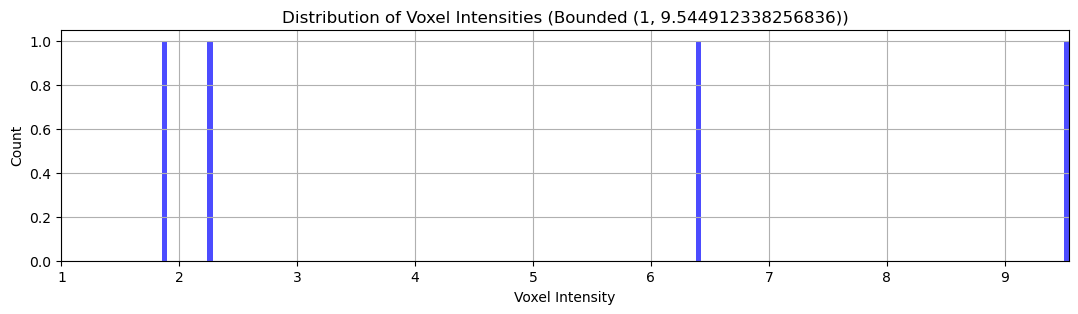

In [21]:
# # Pixel values distribution
# print(recon_without_scatter_estimation.cpu().numpy().shape)

intensity_range = (
    1,
    # recon_without_scatter_estimation.min().item()
    recon_without_scatter_estimation.max().item()
    )

voxel_values = recon_without_scatter_estimation.cpu().numpy().flatten()

plt.figure(figsize=(13, 3))
plt.hist(voxel_values, bins=200, color='blue', alpha=0.7, range=intensity_range)
plt.xlabel('Voxel Intensity')
plt.ylabel('Count')
plt.title(f'Distribution of Voxel Intensities (Bounded {intensity_range})')
plt.grid(True)
plt.xlim(intensity_range)
plt.show()


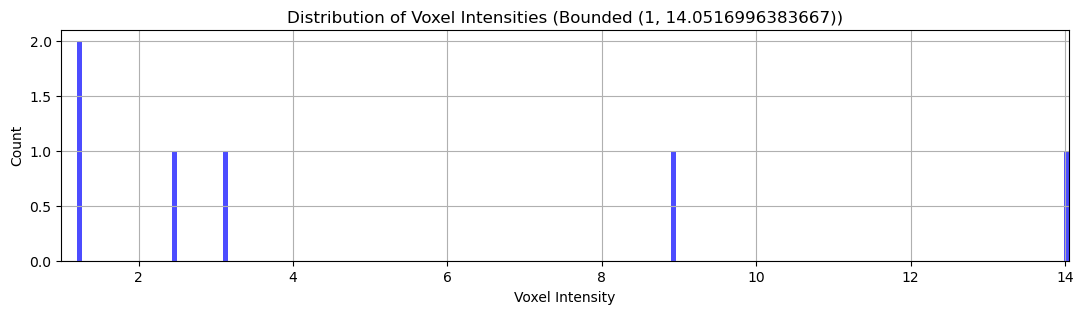

In [22]:
# # Pixel values distribution
# print(recon_without_scatter_estimation.cpu().numpy().shape)

intensity_range = (
    1,
    # recon_without_scatter_estimation.min().item()
    recon_with_scatter_estimation.max().item()
    )

voxel_values = recon_with_scatter_estimation.cpu().numpy().flatten()

plt.figure(figsize=(13, 3))
plt.hist(voxel_values, bins=200, color='blue', alpha=0.7, range=intensity_range)
plt.xlabel('Voxel Intensity')
plt.ylabel('Count')
plt.title(f'Distribution of Voxel Intensities (Bounded {intensity_range})')
plt.grid(True)
plt.xlim(intensity_range)
plt.show()
